
# ALAD - Toy examples¶

This is the notebook that generated Figure 2 in "Adversarially learnt anomaly detection" Credits : https://github.com/ChunyuanLI/ALICE

## Imports


In [1]:
%matplotlib inline

import os
import pdb


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import torch as torch
import torch.nn as nn

from utils.data_gmm import GMM_distribution, sample_GMM, plot_GMM
from utils.data_utils import shuffle, iter_data, ToyDataset
from tqdm import tqdm
import sklearn.datasets

In [3]:

""" parameters """

DATASET = '4gaussians' # 5gaussians, swiss_roll, s_curve
N_NOISY = 100


device = 'cpu'

n_epoch = 500
batch_size  = 1024
dataset_size_x = 512*4
dataset_size_z = 512*4

dataset_size_x_test = 512*2
dataset_size_z_test = 512*2

input_dim = 2
latent_dim = 2
eps_dim = 2

n_layer_disc  = 2
n_hidden_disc = 256
n_layer_gen   = 3
n_hidden_gen  = 256
n_layer_inf   = 2
n_hidden_inf  = 256



In [4]:
""" Create directory for results """
result_dir = 'results/alad_toy/'
directory = result_dir
if not os.path.exists(directory):
    os.makedirs(directory)

## Training dataset

#### 4 or 5 GMM

In [5]:


""" Create dataset """

def four_five_gaussians(p1=0):
    # create X dataset
    global dataset_size_x
    means_x = map(lambda x:  np.array(x), [[2, 2],
                                          [-2, -2],
                                          [2, -2],
                                          [-2, 2],
                                           [0, 0]])
    
    means_x = list(means_x)
    std_x = 0.02
    variances_x = [np.eye(2) * std_x for _ in means_x]

    #contamination = 4.0*p/(1-p)
    priors_x = np.array([1.0, 1.0, 1.0, 1.0, p1])
    priors_x /= sum(priors_x)
    #print(priors_x)
    gaussian_mixture = GMM_distribution(means=means_x,
                                                   variances=variances_x,
                                                   priors=priors_x)
    dataset_x = sample_GMM(dataset_size_x, means_x, variances_x, priors_x, sources=('features', ))
    return dataset_x





You can control the level of the fifth gaussian in the training set with the $p$ parameter

Generate training dataset


In [6]:
dataset_x = four_five_gaussians(p1=0.0)
save_path_x = result_dir + 'X_4gmm_data_train.png'

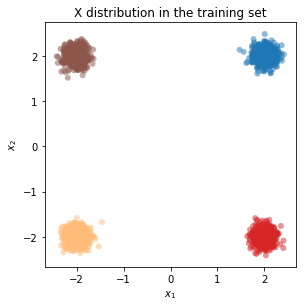

In [7]:
## input x
X_dataset  = dataset_x.data['samples']
X_targets = dataset_x.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_dataset[:, 0], X_dataset[:, 1], c=cm.tab20(X_targets.astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.set_title("X distribution in the training set" )
ax.axis('on')
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()


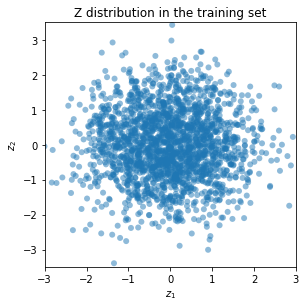

In [8]:


# create Z dataset
means_z = map(lambda x:  np.array(x), [[0, 0]])
means_z = list(means_z)
std_z = 1.0
variances_z = [np.eye(2) * std_z for _ in means_z]
priors_z = [1.0/len(means_z) for _ in means_z]

dataset_z = sample_GMM(dataset_size_z, means_z, variances_z, priors_z, sources=('features', ))
save_path_z = result_dir + 'Z_gmm_data_train.png'

##  input z
Z_dataset = dataset_z.data['samples']
Z_labels  = dataset_z.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_dataset[:, 0], Z_dataset[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.set_title("Z distribution in the training set")
ax.axis('on')
plt.savefig(save_path_z, transparent=True, bbox_inches='tight')
plt.show()



## Networks

In [9]:
""" Networks """

# Models constructors takes tensor arguments only to get input shapes for networks


class Generative_Network(nn.Module):
    def __init__(self,x, input_dim,n_layer, n_hidden, eps_dim, reuse = False):
        super(Generative_Network, self).__init__()
        layers = []
        self.z = z.to(device)
        z_shape = list(z.shape)[1]
            
        layers.append(nn.Linear(z_shape, n_hidden).to(device))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layer-1):
            layers.append(nn.Linear(n_hidden,n_hidden).to(device))
            layers.append(nn.ReLU().to(device))
            
        layers.append(nn.Linear(n_hidden,input_dim).to(device))
        self.gn = nn.Sequential(*layers)
           
            
    def forward(self,z):
        return self.gn(z)


class Inference_Network(nn.Module):
    def __init__(self, x, latent_dim,n_layer, n_hidden, eps_dim, reuse = False):
        super(Inference_Network, self).__init__()
        self.x = x.to(device)
        layers = []
        x_shape = list(x.shape)[1]
        layers.append(nn.Linear(input_dim, n_hidden).to(device))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layer-1):
            layers.append(nn.Linear(n_hidden,n_hidden).to(device))
            layers.append(nn.ReLU().to(device))
            
        layers.append(nn.Linear(n_hidden,latent_dim).to(device))
        self.infn = nn.Sequential(*layers)
            
    def forward(self,x):
        return self.infn(x)

    
class Data_Network_xz(nn.Module,):
    def __init__(self,x, z, n_layers=2, n_hidden=128, activation_fn=None,reuse=False):
        super(Data_Network_xz, self).__init__()
        layers = []
        
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.activation_fn = activation_fn
        self.reuse = reuse
        self.x = x.to(device)
        self.z = z.to(device)
        self.h = torch.cat((x, z), 1).to(device)
        
        h_shape = list(self.h.shape)[1]
        
        layers.append(nn.Linear(h_shape, n_hidden).to(device))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layers-1):
            layers.append(nn.Linear(n_hidden,n_hidden).to(device))
            layers.append(nn.ReLU().to(device))
            
        layers.append(nn.Linear(n_hidden,1).to(device))
        
        if activation_fn:
            layers.append(activation_fn.to(device))
            
        self.dn_xz = nn.Sequential(*layers)
         
        
    def forward(self,x,z):
        h = torch.cat((x,z), 1).to(device)
        res = self.dn_xz(h)
        return res
    
    
class Data_Network_xx(nn.Module):
    def __init__(self,x, x_hat, n_layers=1, n_hidden=128, activation_fn=None,reuse=False):
        super(Data_Network_xx, self).__init__()
        layers = []
        self.h = torch.cat( (x, x_hat), 1).to(device)
        h_shape = list(self.h.shape)[1]
        
        layers.append(nn.Linear(h_shape, n_hidden).to(device))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layers-1):
            layers.append(nn.Linear(n_hidden,n_hidden).to(device))
            layers.append(nn.ReLU().to(device))
            
        layers.append(nn.Linear(n_hidden,1).to(device))
        if activation_fn:
            layers.append(activation_fn.to(device))
        self.dn_xx = nn.Sequential(*layers)
        
    def forward(self,x,x_hat):
        h = torch.cat( (x, x_hat), 1).to(device)
        res = self.dn_xx(h)
        return res
    
    
class Data_Network_zz(nn.Module):
    def __init__(self,z, z_prime, n_layers=1, n_hidden=128, activation_fn=None,reuse=False):
        super(Data_Network_zz, self).__init__()
        layers = []
        self.h = torch.cat( (z, z_prime), 1).to(device)
        h_shape = list(self.h.shape)[1]
        
        layers.append(nn.Linear(h_shape, n_hidden).to(device))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layers-1):
            layers.append(nn.Linear(n_hidden,n_hidden).to(device))
            layers.append(nn.ReLU().to(device))
            
        layers.append(nn.Linear(n_hidden,1).to(device))
        if activation_fn:
            layers.append(activation_fn.to(device))
        self.dn_zz = nn.Sequential(*layers)
        
    def forward(self, z, z_prime):
        h = torch.cat( (z, z_prime), 1).to(device)
        res = self.dn_zz(h)
        return res

In [10]:


x = torch.ones([batch_size, input_dim],dtype = torch.float)
z = torch.ones([batch_size, latent_dim],dtype = torch.float)   
# decoder and encoder
gen = Generative_Network(z, input_dim , n_layer_gen, n_hidden_gen, eps_dim)
inf = Inference_Network(x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim)
dn_xz = Data_Network_xz(x, z, n_layers=n_layer_disc, n_hidden=n_hidden_disc)
dn_zz = Data_Network_zz(z,z)
dn_xx = Data_Network_xx(x,x)



### Optimizers section:

In [11]:
"""qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "inference")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generative")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
dvars_xx = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_xx")
dvars_zz = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_zz")

opt = tf.train.AdamOptimizer(1e-3, beta1=0.5)
train_gen_op =  opt.minimize(gen_loss, var_list=qvars + pvars)
train_disc_op = opt.minimize(disc_loss, var_list=dvars + dvars_xx)"""

# Train disc op does not contain dvars_zz?

disc_params = list(dn_zz.parameters())+list(dn_xz.parameters())+list(dn_xx.parameters())
disc_optimizer = torch.optim.Adam( disc_params, lr=1e-3,betas = (0.5,0.999))

gen_params = list(gen.parameters()) + list(inf.parameters())
gen_optimizer = torch.optim.Adam(gen_params , lr = 1e-3, betas = (0.5,0.999))


### Learning procedure 

In [12]:
"""config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())


FG = []
FD = []

for epoch in tqdm( range(n_epoch), total=n_epoch):
    X_dataset= shuffle(X_dataset)
    Z_dataset= shuffle(Z_dataset)
    i = 0
    for xmb, zmb in iter_data(X_dataset, Z_dataset, size=batch_size):
        i = i + 1
        for _ in range(1):
            f_d, _ = sess.run([disc_loss, train_disc_op], feed_dict={x: xmb, z:zmb})
        for _ in range(5):                                        #  ??? why 5
            f_g, _ = sess.run([[gen_loss, gen_loss_xz, cost_x], train_gen_op], feed_dict={x: xmb, z:zmb})

        FG.append(f_g)
        FD.append(f_d)

    print("epoch %d iter %d: discloss %f genloss %f adv_x %f recons_x %f " % (epoch, i, f_d, f_g[0], f_g[1], f_g[2]))

"""
FG = []
FD = []

for epoch in tqdm( range(n_epoch), total=n_epoch):
    X_dataset= shuffle(X_dataset)
    Z_dataset= shuffle(Z_dataset)
    
    bce = nn.BCELoss()
    sigmoid = nn.Sigmoid()

    i = 0
    f_g= [None]*4
    f_d = None
    
    for xmb, zmb in iter_data(X_dataset, Z_dataset, size=batch_size):
        
        x = torch.Tensor(xmb)
        z = torch.Tensor(zmb)
        i = i+1
        
        p_x = gen(z)
        q_z = inf(x)
        
        decoder_logit = dn_xz(p_x, z)
        encoder_logit = dn_xz(x , q_z)
    
        #NB! Not sure if such xz loss description is correct

      
        decoder_loss = bce(sigmoid(decoder_logit),torch.zeros_like(decoder_logit))
        encoder_loss = bce(sigmoid(encoder_logit),torch.ones_like(encoder_logit))
        
        dis_loss_xz =torch.mean(encoder_loss+decoder_loss)

        decoder_loss2 = bce(sigmoid(decoder_logit),torch.ones_like(decoder_logit))
        encoder_loss2 = bce(sigmoid(encoder_logit),torch.zeros_like(encoder_logit))

        gen_loss_xz = torch.mean((decoder_loss2))  + (torch.mean(encoder_loss2))
        
        
        """rec_z = inference_network(p_x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim, reuse=True)
            rec_x = generative_network(q_z, input_dim , n_layer_gen, n_hidden_gen,  eps_dim, reuse=True)
        """
        
        rec_z = inf(p_x)
        rec_x = gen(q_z)
        

        """
        x_logit_real = data_network_xx(x, x)
        x_logit_fake = data_network_xx(x, rec_x, reuse=True)
        z_logit_real = data_network_zz(z, z)
        z_logit_fake = data_network_zz(z, rec_z,  reuse=True)
        """ 
        x_logit_real = dn_xx(x,x)
        x_logit_fake = dn_xx(x,rec_x)
        z_logit_real = dn_zz(z,z)
        z_logit_fake = dn_zz(z,rec_z)

        """
        x_sigmoid_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_real, labels=tf.ones_like(x_logit_real))
        x_sigmoid_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_fake, labels=tf.zeros_like(x_logit_fake))
        """
        x_sigmoid_real = bce(sigmoid(x_logit_real),torch.ones_like(x_logit_real))
        x_sigmoid_fake = bce(sigmoid(x_logit_fake),torch.zeros_like(x_logit_fake))

        x_sigmoid_real2 = bce(sigmoid(x_logit_real),torch.zeros_like(x_logit_real))
        x_sigmoid_fake2 = bce(sigmoid(x_logit_fake),torch.ones_like(x_logit_fake))

        """x_sigmoid_real2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_real, labels=tf.zeros_like(x_logit_real))
        x_sigmoid_fake2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_fake, labels=tf.ones_like(x_logit_fake))

        z_sigmoid_real2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_real, labels=tf.zeros_like(z_logit_real))
        z_sigmoid_fake2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_fake, labels=tf.ones_like(z_logit_fake))"""

        z_sigmoid_real = bce(sigmoid(z_logit_real),torch.ones_like(z_logit_real))
        z_sigmoid_fake = bce(sigmoid(z_logit_fake),torch.zeros_like(z_logit_fake))

        z_sigmoid_real2 = bce(sigmoid(z_logit_real),torch.zeros_like(z_logit_real))
        z_sigmoid_fake2 = bce(sigmoid(z_logit_fake),torch.ones_like(z_logit_fake))

        """
        dis_loss_x = tf.reduce_mean(x_sigmoid_real + x_sigmoid_fake)
        dis_loss_z = tf.reduce_mean(z_sigmoid_real + z_sigmoid_fake)
        disc_loss = dis_loss_xz + dis_loss_x + dis_loss_z
        """
        dis_loss_x = torch.mean(x_sigmoid_real + x_sigmoid_fake)
        dis_loss_z = torch.mean(z_sigmoid_real + z_sigmoid_fake)
        disc_loss = dis_loss_xz + dis_loss_x + dis_loss_z

        cost_x = torch.mean(x_sigmoid_real2 + x_sigmoid_fake2) 
        cost_z = torch.mean(z_sigmoid_real2 + z_sigmoid_fake2)
        gen_loss = gen_loss_xz + cost_x + cost_z
    
        for _ in range(1):
            disc_optimizer.zero_grad()
            disc_loss.backward(retain_graph = True)
            disc_optimizer.step()
            f_d = disc_loss.data
            
        # In the original article cycle below repeated 5 times, however for 
        # some reasone in my case it leads to insufficient regularization
        # most probably in original notebook this procedure actually do not 
        # lead to 5 iterations of generative model
        
        for _ in range(1):
            gen_optimizer.zero_grad()
            gen_loss.backward(retain_graph = True)
            gen_optimizer.step()
            """
            gen_optimizer.zero_grad()
            gen_loss_xz.backward(retain_graph = True)
            gen_optimizer.step()
            gen_optimizer.zero_grad()
            cost_x.backward(retain_graph = True)
            gen_optimizer.step()
            """
            f_g[0] = gen_loss.data
            f_g[1] = gen_loss_xz.data
            f_g[2] = cost_x.data
            f_g[3] = cost_z.data
    
        FG.append(f_g)
        FD.append(f_d)
    
    print("epoch %d iter %d: discloss %f genloss %f adv_x %f recons_x %f " % (epoch, i, f_d, f_g[0], f_g[1], f_g[2]))



  0%|          | 2/500 [00:00<02:09,  3.86it/s]

epoch 0 iter 2: discloss 4.148564 genloss 4.300996 adv_x 1.532480 recons_x 1.415103 
epoch 1 iter 2: discloss 3.994460 genloss 4.494254 adv_x 1.712762 recons_x 1.416620 


  1%|          | 3/500 [00:00<02:08,  3.88it/s]

epoch 2 iter 2: discloss 3.866141 genloss 4.683023 adv_x 1.895896 recons_x 1.401434 


  1%|          | 4/500 [00:01<02:12,  3.75it/s]

epoch 3 iter 2: discloss 3.678853 genloss 5.136510 adv_x 2.338529 recons_x 1.444515 


  1%|          | 6/500 [00:01<01:58,  4.17it/s]

epoch 4 iter 2: discloss 3.630309 genloss 5.432083 adv_x 2.551373 recons_x 1.504075 
epoch 5 iter 2: discloss 3.631724 genloss 5.512011 adv_x 2.568139 recons_x 1.540152 


  2%|▏         | 8/500 [00:01<01:49,  4.49it/s]

epoch 6 iter 2: discloss 3.635397 genloss 5.280934 adv_x 2.282070 recons_x 1.576033 
epoch 7 iter 2: discloss 3.584792 genloss 5.162020 adv_x 2.069070 recons_x 1.617468 


  2%|▏         | 9/500 [00:02<01:46,  4.60it/s]

epoch 8 iter 2: discloss 3.492369 genloss 5.291238 adv_x 2.112069 recons_x 1.652700 


  2%|▏         | 10/500 [00:02<01:52,  4.37it/s]

epoch 9 iter 2: discloss 3.280381 genloss 6.371634 adv_x 3.138751 recons_x 1.773533 


  2%|▏         | 11/500 [00:02<01:47,  4.53it/s]

epoch 10 iter 2: discloss 3.080702 genloss 7.029434 adv_x 3.782060 recons_x 1.797059 


  3%|▎         | 13/500 [00:02<01:42,  4.77it/s]

epoch 11 iter 2: discloss 3.044044 genloss 7.183659 adv_x 3.923126 recons_x 1.801484 
epoch 12 iter 2: discloss 3.277135 genloss 6.857755 adv_x 3.605023 recons_x 1.805094 


  3%|▎         | 14/500 [00:03<01:51,  4.35it/s]

epoch 13 iter 2: discloss 3.509026 genloss 6.273829 adv_x 3.037773 recons_x 1.780924 


  3%|▎         | 15/500 [00:03<01:55,  4.18it/s]

epoch 14 iter 2: discloss 3.550866 genloss 5.743721 adv_x 2.544005 recons_x 1.741362 


  3%|▎         | 16/500 [00:03<02:07,  3.79it/s]

epoch 15 iter 2: discloss 3.712849 genloss 5.271344 adv_x 2.155722 recons_x 1.648785 


  3%|▎         | 17/500 [00:04<02:01,  3.96it/s]

epoch 16 iter 2: discloss 3.822572 genloss 5.095022 adv_x 2.089913 recons_x 1.518102 


  4%|▎         | 18/500 [00:04<02:13,  3.60it/s]

epoch 17 iter 2: discloss 2.938974 genloss 6.727437 adv_x 3.416281 recons_x 1.656899 


  4%|▍         | 19/500 [00:04<02:07,  3.77it/s]

epoch 18 iter 2: discloss 2.456125 genloss 8.360675 adv_x 4.689668 recons_x 1.989921 


  4%|▍         | 20/500 [00:04<02:04,  3.86it/s]

epoch 19 iter 2: discloss 2.689995 genloss 8.203790 adv_x 4.672455 recons_x 1.963571 


  4%|▍         | 21/500 [00:05<02:16,  3.51it/s]

epoch 20 iter 2: discloss 2.860845 genloss 8.045162 adv_x 4.544189 recons_x 1.982776 


  4%|▍         | 22/500 [00:05<02:15,  3.53it/s]

epoch 21 iter 2: discloss 3.038678 genloss 7.800758 adv_x 4.296629 recons_x 1.989676 


  5%|▍         | 23/500 [00:05<02:11,  3.61it/s]

epoch 22 iter 2: discloss 3.097599 genloss 7.431339 adv_x 3.896309 recons_x 2.027573 


  5%|▍         | 24/500 [00:05<02:03,  3.84it/s]

epoch 23 iter 2: discloss 3.103919 genloss 7.323554 adv_x 3.724106 recons_x 2.092336 


  5%|▌         | 25/500 [00:06<02:00,  3.93it/s]

epoch 24 iter 2: discloss 3.188533 genloss 7.363012 adv_x 3.694592 recons_x 2.183209 


  5%|▌         | 26/500 [00:06<01:59,  3.97it/s]

epoch 25 iter 2: discloss 3.021832 genloss 8.065801 adv_x 4.165314 recons_x 2.429117 


  5%|▌         | 27/500 [00:06<02:13,  3.55it/s]

epoch 26 iter 2: discloss 2.836265 genloss 8.704279 adv_x 4.695703 recons_x 2.524471 


  6%|▌         | 28/500 [00:07<02:12,  3.56it/s]

epoch 27 iter 2: discloss 2.703868 genloss 8.889516 adv_x 4.944819 recons_x 2.387330 


  6%|▌         | 29/500 [00:07<02:09,  3.65it/s]

epoch 28 iter 2: discloss 2.930166 genloss 8.195580 adv_x 4.364135 recons_x 2.144642 


  6%|▌         | 30/500 [00:07<02:00,  3.89it/s]

epoch 29 iter 2: discloss 3.401574 genloss 7.354873 adv_x 3.678988 recons_x 1.867717 


  6%|▌         | 31/500 [00:07<01:56,  4.02it/s]

epoch 30 iter 2: discloss 3.516814 genloss 7.375537 adv_x 3.896434 recons_x 1.757843 


  6%|▋         | 32/500 [00:07<01:50,  4.22it/s]

epoch 31 iter 2: discloss 3.707926 genloss 7.377150 adv_x 4.123788 recons_x 1.701003 


  7%|▋         | 33/500 [00:08<01:47,  4.33it/s]

epoch 32 iter 2: discloss 3.745601 genloss 8.053168 adv_x 4.795936 recons_x 1.769551 


  7%|▋         | 34/500 [00:08<01:46,  4.38it/s]

epoch 33 iter 2: discloss 3.557893 genloss 8.346106 adv_x 4.857080 recons_x 1.915727 


  7%|▋         | 36/500 [00:08<01:38,  4.70it/s]

epoch 34 iter 2: discloss 3.845852 genloss 8.105056 adv_x 4.491728 recons_x 2.001714 
epoch 35 iter 2: discloss 4.309696 genloss 6.986720 adv_x 3.339864 recons_x 2.076939 


  7%|▋         | 37/500 [00:09<01:40,  4.61it/s]

epoch 36 iter 2: discloss 4.404510 genloss 5.531466 adv_x 1.820472 recons_x 2.125557 


  8%|▊         | 39/500 [00:09<01:38,  4.66it/s]

epoch 37 iter 2: discloss 4.364244 genloss 5.605099 adv_x 1.609522 recons_x 2.317435 
epoch 38 iter 2: discloss 3.502035 genloss 6.755943 adv_x 2.398390 recons_x 2.521773 


  8%|▊         | 40/500 [00:09<01:39,  4.65it/s]

epoch 39 iter 2: discloss 3.270267 genloss 7.011598 adv_x 2.732368 recons_x 2.409113 


  8%|▊         | 42/500 [00:10<01:35,  4.81it/s]

epoch 40 iter 2: discloss 3.356590 genloss 6.937497 adv_x 2.770145 recons_x 2.327730 
epoch 41 iter 2: discloss 3.815369 genloss 6.418739 adv_x 2.326026 recons_x 2.311012 


  9%|▊         | 43/500 [00:10<01:33,  4.87it/s]

epoch 42 iter 2: discloss 4.326869 genloss 5.808581 adv_x 1.710367 recons_x 2.286969 


  9%|▉         | 44/500 [00:10<01:36,  4.71it/s]

epoch 43 iter 2: discloss 3.877864 genloss 5.384028 adv_x 1.349094 recons_x 2.187496 


  9%|▉         | 46/500 [00:10<01:34,  4.82it/s]

epoch 44 iter 2: discloss 3.506218 genloss 5.495037 adv_x 1.545055 recons_x 2.145283 
epoch 45 iter 2: discloss 3.429251 genloss 5.565235 adv_x 1.739280 recons_x 2.097438 


  9%|▉         | 47/500 [00:11<01:39,  4.56it/s]

epoch 46 iter 2: discloss 3.282635 genloss 5.748143 adv_x 1.965367 recons_x 2.077379 


 10%|▉         | 48/500 [00:11<01:39,  4.55it/s]

epoch 47 iter 2: discloss 3.294834 genloss 5.876480 adv_x 2.100449 recons_x 2.079945 


 10%|▉         | 49/500 [00:11<01:40,  4.49it/s]

epoch 48 iter 2: discloss 3.402329 genloss 5.865598 adv_x 2.086315 recons_x 2.114812 


 10%|█         | 50/500 [00:11<01:44,  4.31it/s]

epoch 49 iter 2: discloss 3.436275 genloss 5.904072 adv_x 2.111443 recons_x 2.171917 


 10%|█         | 51/500 [00:12<01:47,  4.18it/s]

epoch 50 iter 2: discloss 3.346161 genloss 5.975005 adv_x 2.121537 recons_x 2.247252 


 10%|█         | 52/500 [00:12<01:46,  4.22it/s]

epoch 51 iter 2: discloss 3.277380 genloss 6.013191 adv_x 2.068228 recons_x 2.321041 


 11%|█         | 53/500 [00:12<01:41,  4.42it/s]

epoch 52 iter 2: discloss 3.216515 genloss 6.091918 adv_x 2.073779 recons_x 2.384495 


 11%|█         | 55/500 [00:12<01:35,  4.66it/s]

epoch 53 iter 2: discloss 3.169808 genloss 6.162269 adv_x 2.077579 recons_x 2.454820 
epoch 54 iter 2: discloss 3.040131 genloss 6.322185 adv_x 2.122535 recons_x 2.566388 


 11%|█▏        | 57/500 [00:13<01:32,  4.81it/s]

epoch 55 iter 2: discloss 2.914924 genloss 6.542116 adv_x 2.290419 recons_x 2.601440 
epoch 56 iter 2: discloss 2.856109 genloss 6.759597 adv_x 2.436620 recons_x 2.660568 


 12%|█▏        | 58/500 [00:13<01:42,  4.32it/s]

epoch 57 iter 2: discloss 2.908106 genloss 6.858180 adv_x 2.564577 recons_x 2.630963 


 12%|█▏        | 59/500 [00:14<01:56,  3.78it/s]

epoch 58 iter 2: discloss 2.830867 genloss 7.150147 adv_x 2.826310 recons_x 2.657269 


 12%|█▏        | 60/500 [00:14<02:01,  3.62it/s]

epoch 59 iter 2: discloss 2.872993 genloss 7.046645 adv_x 2.764499 recons_x 2.599472 


 12%|█▏        | 61/500 [00:14<02:11,  3.34it/s]

epoch 60 iter 2: discloss 3.216025 genloss 6.555057 adv_x 2.288960 recons_x 2.525347 


 12%|█▏        | 62/500 [00:14<02:09,  3.38it/s]

epoch 61 iter 2: discloss 3.346132 genloss 6.338159 adv_x 2.074624 recons_x 2.447968 


 13%|█▎        | 63/500 [00:15<02:04,  3.52it/s]

epoch 62 iter 2: discloss 3.208806 genloss 6.361457 adv_x 2.224858 recons_x 2.371685 


 13%|█▎        | 64/500 [00:15<02:00,  3.63it/s]

epoch 63 iter 2: discloss 3.466438 genloss 6.279603 adv_x 2.281619 recons_x 2.259172 


 13%|█▎        | 66/500 [00:15<01:44,  4.15it/s]

epoch 64 iter 2: discloss 3.795335 genloss 6.134689 adv_x 2.051165 recons_x 2.183504 
epoch 65 iter 2: discloss 3.552609 genloss 6.469757 adv_x 2.412432 recons_x 2.204609 


 13%|█▎        | 67/500 [00:16<01:40,  4.31it/s]

epoch 66 iter 2: discloss 3.534907 genloss 6.467550 adv_x 2.486455 recons_x 2.155807 


 14%|█▎        | 68/500 [00:16<01:38,  4.38it/s]

epoch 67 iter 2: discloss 3.618429 genloss 6.033481 adv_x 2.368088 recons_x 1.962664 


 14%|█▍        | 69/500 [00:16<01:54,  3.78it/s]

epoch 68 iter 2: discloss 3.737577 genloss 5.516820 adv_x 1.904961 recons_x 1.912322 


 14%|█▍        | 70/500 [00:16<01:51,  3.87it/s]

epoch 69 iter 2: discloss 3.554904 genloss 5.301641 adv_x 1.754871 recons_x 1.914420 


 14%|█▍        | 71/500 [00:17<01:48,  3.96it/s]

epoch 70 iter 2: discloss 3.578018 genloss 5.238841 adv_x 1.856398 recons_x 1.828298 


 14%|█▍        | 72/500 [00:17<01:54,  3.73it/s]

epoch 71 iter 2: discloss 3.610153 genloss 5.155131 adv_x 1.889452 recons_x 1.730732 


 15%|█▍        | 73/500 [00:17<01:56,  3.68it/s]

epoch 72 iter 2: discloss 3.743863 genloss 5.026941 adv_x 1.909822 recons_x 1.587706 


 15%|█▍        | 74/500 [00:18<02:02,  3.48it/s]

epoch 73 iter 2: discloss 3.955049 genloss 4.805995 adv_x 1.838766 recons_x 1.472016 


 15%|█▌        | 75/500 [00:18<02:03,  3.45it/s]

epoch 74 iter 2: discloss 3.927571 genloss 4.729611 adv_x 1.774074 recons_x 1.476509 


 15%|█▌        | 76/500 [00:18<02:04,  3.41it/s]

epoch 75 iter 2: discloss 3.880089 genloss 4.702458 adv_x 1.766232 recons_x 1.476305 


 15%|█▌        | 77/500 [00:18<01:58,  3.58it/s]

epoch 76 iter 2: discloss 3.805580 genloss 4.820447 adv_x 1.912536 recons_x 1.460002 


 16%|█▌        | 78/500 [00:19<01:51,  3.78it/s]

epoch 77 iter 2: discloss 3.656161 genloss 5.170762 adv_x 2.017287 recons_x 1.696527 


 16%|█▌        | 80/500 [00:19<01:38,  4.28it/s]

epoch 78 iter 2: discloss 3.788943 genloss 5.072485 adv_x 2.134383 recons_x 1.487398 
epoch 79 iter 2: discloss 3.877896 genloss 4.972474 adv_x 2.061747 recons_x 1.470115 


 16%|█▋        | 82/500 [00:19<01:31,  4.56it/s]

epoch 80 iter 2: discloss 3.980806 genloss 4.797208 adv_x 1.888664 recons_x 1.466514 
epoch 81 iter 2: discloss 4.157770 genloss 4.533563 adv_x 1.642311 recons_x 1.466775 


 17%|█▋        | 84/500 [00:20<01:28,  4.70it/s]

epoch 82 iter 2: discloss 4.211798 genloss 4.390299 adv_x 1.447602 recons_x 1.522748 
epoch 83 iter 2: discloss 4.255792 genloss 4.277236 adv_x 1.444893 recons_x 1.426669 


 17%|█▋        | 85/500 [00:20<01:26,  4.77it/s]

epoch 84 iter 2: discloss 4.076755 genloss 4.506603 adv_x 1.476822 recons_x 1.600140 


 17%|█▋        | 86/500 [00:20<01:29,  4.62it/s]

epoch 85 iter 2: discloss 4.010127 genloss 4.562012 adv_x 1.545011 recons_x 1.577832 


 18%|█▊        | 88/500 [00:21<01:25,  4.82it/s]

epoch 86 iter 2: discloss 3.953334 genloss 4.567482 adv_x 1.657835 recons_x 1.480476 
epoch 87 iter 2: discloss 4.025539 genloss 4.501769 adv_x 1.620859 recons_x 1.464719 


 18%|█▊        | 89/500 [00:21<01:25,  4.82it/s]

epoch 88 iter 2: discloss 4.020041 genloss 4.505816 adv_x 1.655701 recons_x 1.438839 


 18%|█▊        | 91/500 [00:21<01:24,  4.86it/s]

epoch 89 iter 2: discloss 3.974788 genloss 4.547000 adv_x 1.687438 recons_x 1.437848 
epoch 90 iter 2: discloss 3.956796 genloss 4.551954 adv_x 1.688672 recons_x 1.435827 


 19%|█▊        | 93/500 [00:22<01:25,  4.77it/s]

epoch 91 iter 2: discloss 4.010076 genloss 4.458202 adv_x 1.627507 recons_x 1.426852 
epoch 92 iter 2: discloss 3.942717 genloss 4.546078 adv_x 1.613294 recons_x 1.517015 


 19%|█▉        | 94/500 [00:22<01:21,  4.97it/s]

epoch 93 iter 2: discloss 3.961329 genloss 4.508252 adv_x 1.670601 recons_x 1.435866 


 19%|█▉        | 96/500 [00:22<01:20,  5.02it/s]

epoch 94 iter 2: discloss 3.941639 genloss 4.495290 adv_x 1.671556 recons_x 1.413171 
epoch 95 iter 2: discloss 3.935176 genloss 4.506634 adv_x 1.691360 recons_x 1.407176 


 20%|█▉        | 98/500 [00:23<01:20,  5.02it/s]

epoch 96 iter 2: discloss 3.937979 genloss 4.510952 adv_x 1.693193 recons_x 1.412048 
epoch 97 iter 2: discloss 3.920407 genloss 4.510082 adv_x 1.704595 recons_x 1.399839 


 20%|█▉        | 99/500 [00:23<01:22,  4.86it/s]

epoch 98 iter 2: discloss 3.923747 genloss 4.508240 adv_x 1.698727 recons_x 1.404268 


 20%|██        | 101/500 [00:23<01:21,  4.89it/s]

epoch 99 iter 2: discloss 3.920681 genloss 4.510504 adv_x 1.707779 recons_x 1.397988 
epoch 100 iter 2: discloss 3.910335 genloss 4.510695 adv_x 1.711497 recons_x 1.393219 


 21%|██        | 103/500 [00:24<01:16,  5.16it/s]

epoch 101 iter 2: discloss 3.902073 genloss 4.508924 adv_x 1.681465 recons_x 1.420689 
epoch 102 iter 2: discloss 3.897767 genloss 4.512663 adv_x 1.692549 recons_x 1.410230 


 21%|██        | 104/500 [00:24<01:17,  5.13it/s]

epoch 103 iter 2: discloss 3.901965 genloss 4.507003 adv_x 1.695316 recons_x 1.400597 


 21%|██        | 106/500 [00:24<01:20,  4.88it/s]

epoch 104 iter 2: discloss 3.897270 genloss 4.504819 adv_x 1.680204 recons_x 1.411110 
epoch 105 iter 2: discloss 3.911292 genloss 4.482872 adv_x 1.654212 recons_x 1.406141 


 21%|██▏       | 107/500 [00:25<01:17,  5.06it/s]

epoch 106 iter 2: discloss 3.908895 genloss 4.480252 adv_x 1.642782 recons_x 1.406552 


 22%|██▏       | 109/500 [00:25<01:15,  5.18it/s]

epoch 107 iter 2: discloss 3.909741 genloss 4.484519 adv_x 1.645071 recons_x 1.402683 
epoch 108 iter 2: discloss 3.888890 genloss 4.517928 adv_x 1.653037 recons_x 1.408918 


 22%|██▏       | 111/500 [00:25<01:17,  5.01it/s]

epoch 109 iter 2: discloss 3.886137 genloss 4.541821 adv_x 1.652696 recons_x 1.421971 
epoch 110 iter 2: discloss 3.852266 genloss 4.576355 adv_x 1.727492 recons_x 1.395569 


 22%|██▏       | 112/500 [00:26<01:23,  4.64it/s]

epoch 111 iter 2: discloss 3.845171 genloss 4.603317 adv_x 1.733728 recons_x 1.420844 


 23%|██▎       | 113/500 [00:26<01:30,  4.29it/s]

epoch 112 iter 2: discloss 3.843252 genloss 4.615088 adv_x 1.743194 recons_x 1.419906 


 23%|██▎       | 115/500 [00:26<01:28,  4.37it/s]

epoch 113 iter 2: discloss 3.844805 genloss 4.603843 adv_x 1.759759 recons_x 1.403522 
epoch 114 iter 2: discloss 3.825787 genloss 4.626287 adv_x 1.785218 recons_x 1.402389 


 23%|██▎       | 116/500 [00:27<01:24,  4.52it/s]

epoch 115 iter 2: discloss 3.818607 genloss 4.643260 adv_x 1.796749 recons_x 1.407193 


 23%|██▎       | 117/500 [00:27<01:28,  4.33it/s]

epoch 116 iter 2: discloss 3.808752 genloss 4.672024 adv_x 1.818709 recons_x 1.409295 


 24%|██▎       | 118/500 [00:27<01:32,  4.15it/s]

epoch 117 iter 2: discloss 3.804269 genloss 4.692886 adv_x 1.846375 recons_x 1.402907 


 24%|██▍       | 119/500 [00:27<01:30,  4.19it/s]

epoch 118 iter 2: discloss 3.810475 genloss 4.700940 adv_x 1.847986 recons_x 1.401745 


 24%|██▍       | 120/500 [00:28<01:29,  4.23it/s]

epoch 119 iter 2: discloss 3.794388 genloss 4.727491 adv_x 1.866953 recons_x 1.402151 


 24%|██▍       | 122/500 [00:28<01:23,  4.53it/s]

epoch 120 iter 2: discloss 3.762751 genloss 4.773094 adv_x 1.851237 recons_x 1.446935 
epoch 121 iter 2: discloss 3.787263 genloss 4.753427 adv_x 1.885009 recons_x 1.402212 


 25%|██▍       | 124/500 [00:28<01:24,  4.47it/s]

epoch 122 iter 2: discloss 3.716972 genloss 4.829134 adv_x 1.931162 recons_x 1.433101 
epoch 123 iter 2: discloss 3.764999 genloss 4.776808 adv_x 1.902767 recons_x 1.413312 


 25%|██▌       | 126/500 [00:29<01:18,  4.74it/s]

epoch 124 iter 2: discloss 3.774261 genloss 4.776686 adv_x 1.883525 recons_x 1.426985 
epoch 125 iter 2: discloss 3.765097 genloss 4.796308 adv_x 1.938262 recons_x 1.409830 


 25%|██▌       | 127/500 [00:29<01:18,  4.78it/s]

epoch 126 iter 2: discloss 3.810030 genloss 4.737417 adv_x 1.872217 recons_x 1.404538 


 26%|██▌       | 129/500 [00:29<01:15,  4.89it/s]

epoch 127 iter 2: discloss 3.827210 genloss 4.677122 adv_x 1.817250 recons_x 1.403535 
epoch 128 iter 2: discloss 3.851163 genloss 4.648109 adv_x 1.784406 recons_x 1.404060 


 26%|██▌       | 131/500 [00:30<01:12,  5.09it/s]

epoch 129 iter 2: discloss 3.839996 genloss 4.648017 adv_x 1.783645 recons_x 1.401916 
epoch 130 iter 2: discloss 3.778726 genloss 4.728770 adv_x 1.781202 recons_x 1.478230 


 26%|██▋       | 132/500 [00:30<01:24,  4.34it/s]

epoch 131 iter 2: discloss 3.807928 genloss 4.682946 adv_x 1.774115 recons_x 1.454671 


 27%|██▋       | 133/500 [00:30<01:21,  4.49it/s]

epoch 132 iter 2: discloss 3.837031 genloss 4.643158 adv_x 1.770702 recons_x 1.415797 


 27%|██▋       | 135/500 [00:31<01:19,  4.57it/s]

epoch 133 iter 2: discloss 3.833561 genloss 4.641553 adv_x 1.747605 recons_x 1.441858 
epoch 134 iter 2: discloss 3.806090 genloss 4.687416 adv_x 1.814344 recons_x 1.409938 


 27%|██▋       | 136/500 [00:31<01:19,  4.57it/s]

epoch 135 iter 2: discloss 3.765788 genloss 4.758789 adv_x 1.873073 recons_x 1.417405 


 27%|██▋       | 137/500 [00:31<01:25,  4.25it/s]

epoch 136 iter 2: discloss 3.779383 genloss 4.713239 adv_x 1.817548 recons_x 1.419325 


 28%|██▊       | 138/500 [00:32<01:25,  4.23it/s]

epoch 137 iter 2: discloss 3.826905 genloss 4.657998 adv_x 1.747287 recons_x 1.405985 


 28%|██▊       | 139/500 [00:32<01:24,  4.25it/s]

epoch 138 iter 2: discloss 3.812388 genloss 4.687513 adv_x 1.675272 recons_x 1.476187 


 28%|██▊       | 140/500 [00:32<01:26,  4.16it/s]

epoch 139 iter 2: discloss 3.612815 genloss 5.041693 adv_x 1.906108 recons_x 1.561772 


 28%|██▊       | 141/500 [00:32<01:28,  4.04it/s]

epoch 140 iter 2: discloss 3.594666 genloss 5.015895 adv_x 1.958720 recons_x 1.505818 


 28%|██▊       | 142/500 [00:33<01:26,  4.14it/s]

epoch 141 iter 2: discloss 3.652230 genloss 4.956540 adv_x 2.002262 recons_x 1.435622 


 29%|██▉       | 144/500 [00:33<01:21,  4.35it/s]

epoch 142 iter 2: discloss 3.755142 genloss 4.782047 adv_x 1.843707 recons_x 1.437178 
epoch 143 iter 2: discloss 3.915065 genloss 4.599954 adv_x 1.699200 recons_x 1.420600 


 29%|██▉       | 145/500 [00:33<01:24,  4.20it/s]

epoch 144 iter 2: discloss 3.919144 genloss 4.621492 adv_x 1.599410 recons_x 1.538973 


 29%|██▉       | 146/500 [00:33<01:25,  4.15it/s]

epoch 145 iter 2: discloss 3.751333 genloss 4.796148 adv_x 1.695783 recons_x 1.576101 


 29%|██▉       | 147/500 [00:34<01:24,  4.15it/s]

epoch 146 iter 2: discloss 3.845810 genloss 4.632761 adv_x 1.703201 recons_x 1.429975 


 30%|██▉       | 148/500 [00:34<01:22,  4.26it/s]

epoch 147 iter 2: discloss 3.893378 genloss 4.663383 adv_x 1.712217 recons_x 1.425732 


 30%|██▉       | 149/500 [00:34<01:20,  4.38it/s]

epoch 148 iter 2: discloss 3.844840 genloss 4.664930 adv_x 1.725074 recons_x 1.430233 


 30%|███       | 151/500 [00:35<01:14,  4.71it/s]

epoch 149 iter 2: discloss 3.807108 genloss 4.714239 adv_x 1.741732 recons_x 1.436736 
epoch 150 iter 2: discloss 3.805930 genloss 4.714759 adv_x 1.771912 recons_x 1.424675 


 31%|███       | 153/500 [00:35<01:09,  5.00it/s]

epoch 151 iter 2: discloss 3.784044 genloss 4.735807 adv_x 1.816501 recons_x 1.424187 
epoch 152 iter 2: discloss 3.819182 genloss 4.699001 adv_x 1.804883 recons_x 1.404565 


 31%|███       | 154/500 [00:35<01:08,  5.08it/s]

epoch 153 iter 2: discloss 3.834553 genloss 4.669171 adv_x 1.754523 recons_x 1.406416 


 31%|███       | 156/500 [00:35<01:06,  5.15it/s]

epoch 154 iter 2: discloss 3.822690 genloss 4.699195 adv_x 1.797248 recons_x 1.399278 
epoch 155 iter 2: discloss 3.782625 genloss 4.730367 adv_x 1.811474 recons_x 1.418353 


 31%|███▏      | 157/500 [00:36<01:10,  4.86it/s]

epoch 156 iter 2: discloss 3.780706 genloss 4.726239 adv_x 1.798113 recons_x 1.414947 


 32%|███▏      | 158/500 [00:36<01:11,  4.76it/s]

epoch 157 iter 2: discloss 3.782001 genloss 4.730742 adv_x 1.804848 recons_x 1.403622 


 32%|███▏      | 159/500 [00:36<01:14,  4.59it/s]

epoch 158 iter 2: discloss 3.752964 genloss 4.793575 adv_x 1.833302 recons_x 1.406287 


 32%|███▏      | 160/500 [00:36<01:16,  4.47it/s]

epoch 159 iter 2: discloss 3.705785 genloss 4.842422 adv_x 1.848737 recons_x 1.427338 


 32%|███▏      | 161/500 [00:37<01:16,  4.42it/s]

epoch 160 iter 2: discloss 3.733592 genloss 4.809217 adv_x 1.783781 recons_x 1.419143 


 32%|███▏      | 162/500 [00:37<01:23,  4.05it/s]

epoch 161 iter 2: discloss 3.765722 genloss 4.785751 adv_x 1.780146 recons_x 1.422365 


 33%|███▎      | 164/500 [00:37<01:18,  4.27it/s]

epoch 162 iter 2: discloss 3.760731 genloss 4.787076 adv_x 1.786166 recons_x 1.441790 
epoch 163 iter 2: discloss 3.740368 genloss 4.821232 adv_x 1.809108 recons_x 1.467392 


 33%|███▎      | 165/500 [00:38<01:25,  3.93it/s]

epoch 164 iter 2: discloss 3.748564 genloss 4.797627 adv_x 1.837376 recons_x 1.429384 


 33%|███▎      | 166/500 [00:38<01:24,  3.96it/s]

epoch 165 iter 2: discloss 3.770745 genloss 4.799501 adv_x 1.856843 recons_x 1.421487 


 33%|███▎      | 167/500 [00:38<01:20,  4.16it/s]

epoch 166 iter 2: discloss 3.842218 genloss 4.688646 adv_x 1.741209 recons_x 1.429810 


 34%|███▍      | 169/500 [00:39<01:15,  4.38it/s]

epoch 167 iter 2: discloss 3.883564 genloss 4.672940 adv_x 1.622816 recons_x 1.512349 
epoch 168 iter 2: discloss 3.817704 genloss 4.717295 adv_x 1.728656 recons_x 1.435158 


 34%|███▍      | 171/500 [00:39<01:07,  4.90it/s]

epoch 169 iter 2: discloss 3.691619 genloss 4.879334 adv_x 1.915234 recons_x 1.419132 
epoch 170 iter 2: discloss 3.692524 genloss 4.901523 adv_x 1.926565 recons_x 1.411550 


 35%|███▍      | 173/500 [00:39<01:03,  5.14it/s]

epoch 171 iter 2: discloss 3.758740 genloss 4.790780 adv_x 1.790516 recons_x 1.442852 
epoch 172 iter 2: discloss 3.789236 genloss 4.756490 adv_x 1.758828 recons_x 1.438954 


 35%|███▌      | 175/500 [00:40<00:59,  5.45it/s]

epoch 173 iter 2: discloss 3.822817 genloss 4.783552 adv_x 1.755074 recons_x 1.428496 
epoch 174 iter 2: discloss 3.751342 genloss 4.890016 adv_x 1.801939 recons_x 1.425575 


 35%|███▌      | 177/500 [00:40<00:56,  5.67it/s]

epoch 175 iter 2: discloss 3.727139 genloss 4.976323 adv_x 1.924637 recons_x 1.427781 
epoch 176 iter 2: discloss 3.699576 genloss 4.870708 adv_x 1.863929 recons_x 1.466501 


 36%|███▌      | 179/500 [00:40<00:58,  5.52it/s]

epoch 177 iter 2: discloss 3.949067 genloss 4.596042 adv_x 1.569433 recons_x 1.449205 
epoch 178 iter 2: discloss 3.723610 genloss 4.810701 adv_x 1.742914 recons_x 1.460361 


 36%|███▌      | 181/500 [00:41<00:57,  5.58it/s]

epoch 179 iter 2: discloss 3.816195 genloss 4.716640 adv_x 1.682727 recons_x 1.412857 
epoch 180 iter 2: discloss 3.695870 genloss 4.904338 adv_x 1.817069 recons_x 1.436695 


 36%|███▋      | 182/500 [00:41<00:57,  5.56it/s]

epoch 181 iter 2: discloss 3.721056 genloss 4.825782 adv_x 1.782160 recons_x 1.429923 


 37%|███▋      | 184/500 [00:41<00:57,  5.49it/s]

epoch 182 iter 2: discloss 3.745728 genloss 4.795535 adv_x 1.767853 recons_x 1.417562 
epoch 183 iter 2: discloss 3.730160 genloss 4.860273 adv_x 1.805398 recons_x 1.416797 


 37%|███▋      | 186/500 [00:42<00:54,  5.73it/s]

epoch 184 iter 2: discloss 3.662021 genloss 5.029562 adv_x 1.965531 recons_x 1.422889 
epoch 185 iter 2: discloss 3.540756 genloss 5.174314 adv_x 2.050148 recons_x 1.482903 


 38%|███▊      | 188/500 [00:42<00:54,  5.77it/s]

epoch 186 iter 2: discloss 3.619951 genloss 5.076406 adv_x 1.994297 recons_x 1.437338 
epoch 187 iter 2: discloss 3.701015 genloss 4.952723 adv_x 1.857415 recons_x 1.483320 


 38%|███▊      | 190/500 [00:42<00:55,  5.59it/s]

epoch 188 iter 2: discloss 3.897926 genloss 4.765087 adv_x 1.782225 recons_x 1.415349 
epoch 189 iter 2: discloss 3.938449 genloss 4.766380 adv_x 1.734283 recons_x 1.455064 


 38%|███▊      | 192/500 [00:43<00:56,  5.50it/s]

epoch 190 iter 2: discloss 4.051369 genloss 4.618354 adv_x 1.586638 recons_x 1.461969 
epoch 191 iter 2: discloss 3.995485 genloss 4.605576 adv_x 1.488356 recons_x 1.522785 


 39%|███▉      | 194/500 [00:43<00:53,  5.67it/s]

epoch 192 iter 2: discloss 3.892513 genloss 4.725165 adv_x 1.705277 recons_x 1.460463 
epoch 193 iter 2: discloss 3.827850 genloss 4.693048 adv_x 1.655574 recons_x 1.429378 


 39%|███▉      | 196/500 [00:43<00:55,  5.53it/s]

epoch 194 iter 2: discloss 3.784088 genloss 4.737950 adv_x 1.717799 recons_x 1.416828 
epoch 195 iter 2: discloss 3.761125 genloss 4.745571 adv_x 1.741178 recons_x 1.406505 


 40%|███▉      | 198/500 [00:44<00:56,  5.37it/s]

epoch 196 iter 2: discloss 3.747082 genloss 4.764026 adv_x 1.764683 recons_x 1.417835 
epoch 197 iter 2: discloss 3.745764 genloss 4.773180 adv_x 1.769291 recons_x 1.417738 


 40%|████      | 200/500 [00:44<00:55,  5.37it/s]

epoch 198 iter 2: discloss 3.758547 genloss 4.759254 adv_x 1.737379 recons_x 1.414898 
epoch 199 iter 2: discloss 3.728610 genloss 4.829557 adv_x 1.783910 recons_x 1.418427 


 40%|████      | 202/500 [00:45<00:52,  5.70it/s]

epoch 200 iter 2: discloss 3.653807 genloss 4.944937 adv_x 1.837211 recons_x 1.446452 
epoch 201 iter 2: discloss 3.631769 genloss 5.000620 adv_x 1.927354 recons_x 1.425642 


 41%|████      | 204/500 [00:45<00:50,  5.82it/s]

epoch 202 iter 2: discloss 3.723870 genloss 4.847193 adv_x 1.840952 recons_x 1.413635 
epoch 203 iter 2: discloss 3.758561 genloss 4.792071 adv_x 1.749800 recons_x 1.444980 


 41%|████      | 206/500 [00:45<00:51,  5.68it/s]

epoch 204 iter 2: discloss 3.740841 genloss 4.843956 adv_x 1.754897 recons_x 1.456627 
epoch 205 iter 2: discloss 3.703457 genloss 4.880432 adv_x 1.772203 recons_x 1.444960 


 42%|████▏     | 208/500 [00:46<00:49,  5.86it/s]

epoch 206 iter 2: discloss 3.674847 genloss 4.935383 adv_x 1.829767 recons_x 1.425959 
epoch 207 iter 2: discloss 3.697483 genloss 4.955345 adv_x 1.835413 recons_x 1.425689 


 42%|████▏     | 209/500 [00:46<01:01,  4.71it/s]

epoch 208 iter 2: discloss 3.701423 genloss 5.066460 adv_x 1.970823 recons_x 1.416984 


 42%|████▏     | 211/500 [00:46<01:03,  4.55it/s]

epoch 209 iter 2: discloss 3.686061 genloss 5.011137 adv_x 1.967207 recons_x 1.414368 
epoch 210 iter 2: discloss 3.780257 genloss 4.893453 adv_x 1.835600 recons_x 1.427929 


 42%|████▏     | 212/500 [00:47<01:00,  4.80it/s]

epoch 211 iter 2: discloss 3.728989 genloss 4.887842 adv_x 1.824686 recons_x 1.454352 


 43%|████▎     | 213/500 [00:47<01:00,  4.78it/s]

epoch 212 iter 2: discloss 3.816848 genloss 4.740182 adv_x 1.700326 recons_x 1.424183 


 43%|████▎     | 214/500 [00:47<01:03,  4.47it/s]

epoch 213 iter 2: discloss 3.702854 genloss 4.918865 adv_x 1.710872 recons_x 1.518759 


 43%|████▎     | 215/500 [00:47<01:17,  3.69it/s]

epoch 214 iter 2: discloss 3.697592 genloss 4.929908 adv_x 1.893168 recons_x 1.412145 


 43%|████▎     | 217/500 [00:48<01:11,  3.95it/s]

epoch 215 iter 2: discloss 3.670947 genloss 4.923298 adv_x 1.879350 recons_x 1.441110 
epoch 216 iter 2: discloss 3.714321 genloss 4.849341 adv_x 1.769749 recons_x 1.444810 


 44%|████▎     | 218/500 [00:48<01:14,  3.77it/s]

epoch 217 iter 2: discloss 3.715960 genloss 4.863750 adv_x 1.771395 recons_x 1.450011 


 44%|████▍     | 219/500 [00:48<01:11,  3.94it/s]

epoch 218 iter 2: discloss 3.585337 genloss 5.093927 adv_x 1.820317 recons_x 1.574508 


 44%|████▍     | 221/500 [00:49<01:02,  4.48it/s]

epoch 219 iter 2: discloss 3.654581 genloss 4.989349 adv_x 1.877626 recons_x 1.437222 
epoch 220 iter 2: discloss 3.682688 genloss 4.946662 adv_x 1.893219 recons_x 1.429934 


 44%|████▍     | 222/500 [00:49<00:58,  4.79it/s]

epoch 221 iter 2: discloss 3.755562 genloss 4.845556 adv_x 1.841474 recons_x 1.416890 


 45%|████▍     | 224/500 [00:49<00:55,  4.99it/s]

epoch 222 iter 2: discloss 3.798938 genloss 4.758504 adv_x 1.761819 recons_x 1.418260 
epoch 223 iter 2: discloss 3.705151 genloss 4.875148 adv_x 1.838255 recons_x 1.428200 


 45%|████▌     | 226/500 [00:50<00:53,  5.17it/s]

epoch 224 iter 2: discloss 3.661173 genloss 4.938445 adv_x 1.838971 recons_x 1.421945 
epoch 225 iter 2: discloss 3.701661 genloss 4.892161 adv_x 1.853346 recons_x 1.410774 


 45%|████▌     | 227/500 [00:50<00:52,  5.20it/s]

epoch 226 iter 2: discloss 3.758903 genloss 4.798132 adv_x 1.737833 recons_x 1.420249 


 46%|████▌     | 228/500 [00:50<00:58,  4.64it/s]

epoch 227 iter 2: discloss 3.663292 genloss 4.948266 adv_x 1.763713 recons_x 1.469551 


 46%|████▌     | 229/500 [00:50<01:00,  4.51it/s]

epoch 228 iter 2: discloss 3.570826 genloss 5.094624 adv_x 1.917298 recons_x 1.449008 


 46%|████▌     | 230/500 [00:51<01:02,  4.34it/s]

epoch 229 iter 2: discloss 3.438976 genloss 5.364282 adv_x 2.126852 recons_x 1.465657 


 46%|████▌     | 231/500 [00:51<01:02,  4.34it/s]

epoch 230 iter 2: discloss 3.552284 genloss 5.261629 adv_x 2.105401 recons_x 1.443658 


 46%|████▋     | 232/500 [00:51<00:59,  4.49it/s]

epoch 231 iter 2: discloss 3.746471 genloss 4.949917 adv_x 1.878151 recons_x 1.436206 


 47%|████▋     | 233/500 [00:51<01:02,  4.26it/s]

epoch 232 iter 2: discloss 3.873746 genloss 4.788851 adv_x 1.706481 recons_x 1.448096 


 47%|████▋     | 234/500 [00:52<01:03,  4.18it/s]

epoch 233 iter 2: discloss 3.548527 genloss 5.130733 adv_x 1.851356 recons_x 1.570103 


 47%|████▋     | 235/500 [00:52<01:05,  4.06it/s]

epoch 234 iter 2: discloss 3.703428 genloss 4.913896 adv_x 1.813220 recons_x 1.428135 


 47%|████▋     | 236/500 [00:52<01:08,  3.88it/s]

epoch 235 iter 2: discloss 3.678334 genloss 4.970226 adv_x 1.916890 recons_x 1.406959 


 48%|████▊     | 238/500 [00:53<00:59,  4.38it/s]

epoch 236 iter 2: discloss 3.746940 genloss 4.856677 adv_x 1.778760 recons_x 1.415387 
epoch 237 iter 2: discloss 3.656738 genloss 4.959727 adv_x 1.849730 recons_x 1.450303 


 48%|████▊     | 240/500 [00:53<00:58,  4.41it/s]

epoch 238 iter 2: discloss 3.596986 genloss 5.028919 adv_x 1.897959 recons_x 1.450610 
epoch 239 iter 2: discloss 3.532601 genloss 5.172363 adv_x 2.026206 recons_x 1.445408 


 48%|████▊     | 241/500 [00:53<00:57,  4.49it/s]

epoch 240 iter 2: discloss 3.446747 genloss 5.369856 adv_x 2.103935 recons_x 1.458079 


 48%|████▊     | 242/500 [00:54<01:02,  4.14it/s]

epoch 241 iter 2: discloss 3.628404 genloss 5.161612 adv_x 1.960873 recons_x 1.444027 


 49%|████▊     | 243/500 [00:54<01:03,  4.03it/s]

epoch 242 iter 2: discloss 3.698980 genloss 4.996855 adv_x 1.788203 recons_x 1.529291 


 49%|████▉     | 244/500 [00:54<01:03,  4.06it/s]

epoch 243 iter 2: discloss 3.753091 genloss 4.874676 adv_x 1.776667 recons_x 1.440320 


 49%|████▉     | 245/500 [00:54<01:06,  3.83it/s]

epoch 244 iter 2: discloss 3.641419 genloss 5.024556 adv_x 1.936627 recons_x 1.442672 


 49%|████▉     | 246/500 [00:55<01:08,  3.73it/s]

epoch 245 iter 2: discloss 3.647803 genloss 4.983721 adv_x 1.897095 recons_x 1.412342 


 49%|████▉     | 247/500 [00:55<01:05,  3.86it/s]

epoch 246 iter 2: discloss 3.652491 genloss 4.960610 adv_x 1.875101 recons_x 1.408575 


 50%|████▉     | 248/500 [00:55<01:06,  3.80it/s]

epoch 247 iter 2: discloss 3.640003 genloss 4.992179 adv_x 1.888038 recons_x 1.424369 


 50%|████▉     | 249/500 [00:55<01:09,  3.64it/s]

epoch 248 iter 2: discloss 3.585172 genloss 5.091807 adv_x 1.917000 recons_x 1.468297 


 50%|█████     | 250/500 [00:56<01:10,  3.53it/s]

epoch 249 iter 2: discloss 3.516574 genloss 5.261863 adv_x 2.023509 recons_x 1.477822 


 50%|█████     | 251/500 [00:56<01:09,  3.61it/s]

epoch 250 iter 2: discloss 3.496553 genloss 5.314917 adv_x 2.100594 recons_x 1.438652 


 51%|█████     | 253/500 [00:56<00:59,  4.16it/s]

epoch 251 iter 2: discloss 3.531138 genloss 5.289609 adv_x 2.121271 recons_x 1.435882 
epoch 252 iter 2: discloss 3.377886 genloss 5.463988 adv_x 2.148167 recons_x 1.490721 


 51%|█████     | 254/500 [00:57<01:00,  4.08it/s]

epoch 253 iter 2: discloss 3.699752 genloss 4.996784 adv_x 1.853996 recons_x 1.442109 


 51%|█████     | 255/500 [00:57<01:03,  3.87it/s]

epoch 254 iter 2: discloss 3.720541 genloss 5.206816 adv_x 1.658163 recons_x 1.792773 


 51%|█████     | 256/500 [00:57<01:09,  3.53it/s]

epoch 255 iter 2: discloss 3.652315 genloss 5.091495 adv_x 1.788504 recons_x 1.470055 


 51%|█████▏    | 257/500 [00:58<01:12,  3.36it/s]

epoch 256 iter 2: discloss 3.585618 genloss 5.212152 adv_x 1.971973 recons_x 1.428782 


 52%|█████▏    | 259/500 [00:58<00:59,  4.07it/s]

epoch 257 iter 2: discloss 3.401389 genloss 5.410527 adv_x 2.072229 recons_x 1.490135 
epoch 258 iter 2: discloss 3.583313 genloss 5.277296 adv_x 2.129595 recons_x 1.419429 


 52%|█████▏    | 261/500 [00:58<00:53,  4.44it/s]

epoch 259 iter 2: discloss 3.697126 genloss 5.091662 adv_x 1.955005 recons_x 1.431770 
epoch 260 iter 2: discloss 3.795314 genloss 4.921667 adv_x 1.738627 recons_x 1.443725 


 53%|█████▎    | 263/500 [00:59<00:46,  5.07it/s]

epoch 261 iter 2: discloss 3.525755 genloss 5.355552 adv_x 1.781302 recons_x 1.729664 
epoch 262 iter 2: discloss 3.640138 genloss 5.023137 adv_x 1.746645 recons_x 1.479780 


 53%|█████▎    | 265/500 [00:59<00:44,  5.27it/s]

epoch 263 iter 2: discloss 3.654455 genloss 5.009417 adv_x 1.781436 recons_x 1.445994 
epoch 264 iter 2: discloss 3.571367 genloss 5.095957 adv_x 1.929763 recons_x 1.443833 


 53%|█████▎    | 266/500 [00:59<00:42,  5.46it/s]

epoch 265 iter 2: discloss 3.411007 genloss 5.367110 adv_x 2.163980 recons_x 1.451769 


 53%|█████▎    | 267/500 [01:00<00:44,  5.29it/s]

epoch 266 iter 2: discloss 3.359338 genloss 5.504439 adv_x 2.266722 recons_x 1.465079 


 54%|█████▍    | 269/500 [01:00<00:46,  5.00it/s]

epoch 267 iter 2: discloss 3.514866 genloss 5.318336 adv_x 2.155920 recons_x 1.429710 
epoch 268 iter 2: discloss 3.541828 genloss 5.397192 adv_x 2.041283 recons_x 1.527165 


 54%|█████▍    | 270/500 [01:00<00:45,  5.04it/s]

epoch 269 iter 2: discloss 3.498124 genloss 5.413434 adv_x 2.130400 recons_x 1.458349 


 54%|█████▍    | 272/500 [01:01<00:46,  4.92it/s]

epoch 270 iter 2: discloss 3.457789 genloss 5.374320 adv_x 2.151777 recons_x 1.469763 
epoch 271 iter 2: discloss 3.938260 genloss 4.807486 adv_x 1.661789 recons_x 1.424067 


 55%|█████▍    | 273/500 [01:01<00:45,  5.02it/s]

epoch 272 iter 2: discloss 3.863946 genloss 4.838099 adv_x 1.619471 recons_x 1.487481 


 55%|█████▌    | 275/500 [01:01<00:45,  4.92it/s]

epoch 273 iter 2: discloss 3.591527 genloss 5.159415 adv_x 1.866456 recons_x 1.446323 
epoch 274 iter 2: discloss 3.562476 genloss 5.159751 adv_x 1.990104 recons_x 1.415244 


 55%|█████▌    | 277/500 [01:02<00:41,  5.39it/s]

epoch 275 iter 2: discloss 3.605070 genloss 5.088070 adv_x 1.920356 recons_x 1.425596 
epoch 276 iter 2: discloss 3.652129 genloss 5.055717 adv_x 1.810547 recons_x 1.456359 


 56%|█████▌    | 278/500 [01:02<00:40,  5.53it/s]

epoch 277 iter 2: discloss 3.665700 genloss 5.060142 adv_x 1.829064 recons_x 1.451725 


 56%|█████▌    | 280/500 [01:02<00:42,  5.22it/s]

epoch 278 iter 2: discloss 3.577242 genloss 5.187508 adv_x 1.914397 recons_x 1.448794 
epoch 279 iter 2: discloss 3.458707 genloss 5.384160 adv_x 2.083287 recons_x 1.467278 


 56%|█████▋    | 282/500 [01:03<00:42,  5.11it/s]

epoch 280 iter 2: discloss 3.392981 genloss 5.531620 adv_x 2.265527 recons_x 1.447294 
epoch 281 iter 2: discloss 3.523078 genloss 5.357673 adv_x 2.209807 recons_x 1.428948 


 57%|█████▋    | 283/500 [01:03<00:46,  4.67it/s]

epoch 282 iter 2: discloss 3.626327 genloss 5.213840 adv_x 2.048276 recons_x 1.445943 


 57%|█████▋    | 284/500 [01:03<00:47,  4.59it/s]

epoch 283 iter 2: discloss 3.647131 genloss 5.107846 adv_x 1.909269 recons_x 1.471478 


 57%|█████▋    | 286/500 [01:03<00:44,  4.83it/s]

epoch 284 iter 2: discloss 3.620634 genloss 5.165754 adv_x 1.848189 recons_x 1.484913 
epoch 285 iter 2: discloss 3.648263 genloss 5.093384 adv_x 1.882176 recons_x 1.435477 


 58%|█████▊    | 288/500 [01:04<00:44,  4.80it/s]

epoch 286 iter 2: discloss 3.568521 genloss 5.176718 adv_x 1.988299 recons_x 1.428626 
epoch 287 iter 2: discloss 3.650311 genloss 5.042080 adv_x 1.887492 recons_x 1.423716 


 58%|█████▊    | 289/500 [01:04<00:46,  4.57it/s]

epoch 288 iter 2: discloss 3.614080 genloss 5.078335 adv_x 1.864043 recons_x 1.442187 


 58%|█████▊    | 291/500 [01:05<00:45,  4.59it/s]

epoch 289 iter 2: discloss 3.570190 genloss 5.191669 adv_x 2.030717 recons_x 1.440544 
epoch 290 iter 2: discloss 3.367463 genloss 5.560120 adv_x 2.290318 recons_x 1.442130 


 59%|█████▊    | 293/500 [01:05<00:40,  5.08it/s]

epoch 291 iter 2: discloss 3.321477 genloss 5.685778 adv_x 2.432670 recons_x 1.459505 
epoch 292 iter 2: discloss 3.481928 genloss 5.486465 adv_x 2.336617 recons_x 1.415938 


 59%|█████▉    | 294/500 [01:05<00:42,  4.82it/s]

epoch 293 iter 2: discloss 3.601463 genloss 5.191794 adv_x 2.006705 recons_x 1.431509 


 59%|█████▉    | 295/500 [01:05<00:48,  4.22it/s]

epoch 294 iter 2: discloss 3.761869 genloss 4.974864 adv_x 1.776864 recons_x 1.468515 


 59%|█████▉    | 296/500 [01:06<00:46,  4.37it/s]

epoch 295 iter 2: discloss 3.716557 genloss 5.055518 adv_x 1.874123 recons_x 1.443081 


 60%|█████▉    | 298/500 [01:06<00:42,  4.70it/s]

epoch 296 iter 2: discloss 3.584799 genloss 5.150429 adv_x 1.926796 recons_x 1.443381 
epoch 297 iter 2: discloss 3.547046 genloss 5.219786 adv_x 2.029137 recons_x 1.427765 


 60%|█████▉    | 299/500 [01:06<00:45,  4.40it/s]

epoch 298 iter 2: discloss 3.492595 genloss 5.310035 adv_x 2.057227 recons_x 1.458621 


 60%|██████    | 300/500 [01:07<00:45,  4.37it/s]

epoch 299 iter 2: discloss 3.531336 genloss 5.280948 adv_x 1.975604 recons_x 1.481575 


 60%|██████    | 301/500 [01:07<00:44,  4.45it/s]

epoch 300 iter 2: discloss 3.629967 genloss 5.231744 adv_x 1.927940 recons_x 1.469276 


 60%|██████    | 302/500 [01:07<00:43,  4.56it/s]

epoch 301 iter 2: discloss 3.465885 genloss 5.500964 adv_x 2.082561 recons_x 1.495847 


 61%|██████    | 304/500 [01:07<00:46,  4.21it/s]

epoch 302 iter 2: discloss 3.455978 genloss 5.587512 adv_x 2.274148 recons_x 1.466055 
epoch 303 iter 2: discloss 3.553667 genloss 5.356095 adv_x 2.233613 recons_x 1.415975 


 61%|██████    | 306/500 [01:08<00:41,  4.64it/s]

epoch 304 iter 2: discloss 3.542858 genloss 5.326523 adv_x 2.146027 recons_x 1.440727 
epoch 305 iter 2: discloss 3.570178 genloss 5.234473 adv_x 2.034091 recons_x 1.435549 


 61%|██████▏   | 307/500 [01:08<00:43,  4.40it/s]

epoch 306 iter 2: discloss 3.738932 genloss 5.021182 adv_x 1.917315 recons_x 1.427725 


 62%|██████▏   | 308/500 [01:08<00:46,  4.09it/s]

epoch 307 iter 2: discloss 3.578206 genloss 5.247252 adv_x 1.934660 recons_x 1.507380 


 62%|██████▏   | 309/500 [01:09<00:48,  3.95it/s]

epoch 308 iter 2: discloss 3.542671 genloss 5.239913 adv_x 2.032335 recons_x 1.455755 


 62%|██████▏   | 310/500 [01:09<00:48,  3.92it/s]

epoch 309 iter 2: discloss 3.474240 genloss 5.353354 adv_x 2.123489 recons_x 1.450868 


 62%|██████▏   | 311/500 [01:09<00:47,  3.99it/s]

epoch 310 iter 2: discloss 3.493097 genloss 5.366343 adv_x 2.080869 recons_x 1.452338 


 62%|██████▏   | 312/500 [01:09<00:49,  3.79it/s]

epoch 311 iter 2: discloss 3.480591 genloss 5.478971 adv_x 2.065680 recons_x 1.504503 


 63%|██████▎   | 313/500 [01:10<00:49,  3.81it/s]

epoch 312 iter 2: discloss 3.356610 genloss 5.697093 adv_x 2.212380 recons_x 1.531712 


 63%|██████▎   | 314/500 [01:10<00:50,  3.72it/s]

epoch 313 iter 2: discloss 3.369653 genloss 5.745197 adv_x 2.433918 recons_x 1.433373 


 63%|██████▎   | 315/500 [01:10<00:47,  3.86it/s]

epoch 314 iter 2: discloss 3.635885 genloss 5.320627 adv_x 2.196582 recons_x 1.435940 


 63%|██████▎   | 316/500 [01:11<00:48,  3.79it/s]

epoch 315 iter 2: discloss 3.778829 genloss 5.037504 adv_x 1.781661 recons_x 1.454386 


 63%|██████▎   | 317/500 [01:11<00:49,  3.73it/s]

epoch 316 iter 2: discloss 3.559278 genloss 5.281756 adv_x 1.901121 recons_x 1.504158 


 64%|██████▎   | 318/500 [01:11<00:46,  3.88it/s]

epoch 317 iter 2: discloss 3.595200 genloss 5.247676 adv_x 1.958242 recons_x 1.506810 


 64%|██████▍   | 319/500 [01:11<00:46,  3.92it/s]

epoch 318 iter 2: discloss 3.530556 genloss 5.299743 adv_x 2.070482 recons_x 1.429784 


 64%|██████▍   | 320/500 [01:12<00:48,  3.73it/s]

epoch 319 iter 2: discloss 3.587984 genloss 5.197302 adv_x 2.014875 recons_x 1.421252 


 64%|██████▍   | 321/500 [01:12<00:46,  3.86it/s]

epoch 320 iter 2: discloss 3.498014 genloss 5.285368 adv_x 2.010052 recons_x 1.442313 


 64%|██████▍   | 322/500 [01:12<00:43,  4.10it/s]

epoch 321 iter 2: discloss 3.451501 genloss 5.393946 adv_x 2.067447 recons_x 1.449172 


 65%|██████▍   | 324/500 [01:12<00:39,  4.41it/s]

epoch 322 iter 2: discloss 3.427021 genloss 5.502913 adv_x 2.140934 recons_x 1.446237 
epoch 323 iter 2: discloss 3.446532 genloss 5.465943 adv_x 2.142661 recons_x 1.440830 


 65%|██████▌   | 326/500 [01:13<00:35,  4.88it/s]

epoch 324 iter 2: discloss 3.510398 genloss 5.419642 adv_x 2.093754 recons_x 1.466190 
epoch 325 iter 2: discloss 3.538571 genloss 5.385198 adv_x 2.114983 recons_x 1.451772 


 65%|██████▌   | 327/500 [01:13<00:37,  4.55it/s]

epoch 326 iter 2: discloss 3.507330 genloss 5.349396 adv_x 2.095434 recons_x 1.446788 


 66%|██████▌   | 328/500 [01:13<00:40,  4.25it/s]

epoch 327 iter 2: discloss 3.681285 genloss 5.083568 adv_x 1.959889 recons_x 1.416455 


 66%|██████▌   | 330/500 [01:14<00:36,  4.67it/s]

epoch 328 iter 2: discloss 3.610641 genloss 5.247505 adv_x 2.009759 recons_x 1.450294 
epoch 329 iter 2: discloss 3.518625 genloss 5.393690 adv_x 2.099125 recons_x 1.453488 


 66%|██████▌   | 331/500 [01:14<00:38,  4.42it/s]

epoch 330 iter 2: discloss 3.575041 genloss 5.283484 adv_x 2.120984 recons_x 1.421964 


 66%|██████▋   | 332/500 [01:14<00:42,  3.94it/s]

epoch 331 iter 2: discloss 3.526524 genloss 5.323614 adv_x 2.072133 recons_x 1.438806 


 67%|██████▋   | 333/500 [01:15<00:41,  3.99it/s]

epoch 332 iter 2: discloss 3.499096 genloss 5.376539 adv_x 2.095155 recons_x 1.446000 


 67%|██████▋   | 334/500 [01:15<00:41,  4.03it/s]

epoch 333 iter 2: discloss 3.362058 genloss 5.669793 adv_x 2.292259 recons_x 1.458322 


 67%|██████▋   | 335/500 [01:15<00:40,  4.12it/s]

epoch 334 iter 2: discloss 3.233702 genloss 6.009667 adv_x 2.543839 recons_x 1.483235 


 67%|██████▋   | 337/500 [01:15<00:36,  4.50it/s]

epoch 335 iter 2: discloss 3.192387 genloss 6.090181 adv_x 2.659560 recons_x 1.487122 
epoch 336 iter 2: discloss 3.416796 genloss 5.642863 adv_x 2.378818 recons_x 1.469825 


 68%|██████▊   | 338/500 [01:16<00:37,  4.28it/s]

epoch 337 iter 2: discloss 3.838098 genloss 5.035475 adv_x 1.800967 recons_x 1.507366 


 68%|██████▊   | 339/500 [01:16<00:42,  3.81it/s]

epoch 338 iter 2: discloss 3.804598 genloss 5.084637 adv_x 1.790772 recons_x 1.533589 


 68%|██████▊   | 341/500 [01:16<00:37,  4.25it/s]

epoch 339 iter 2: discloss 3.694053 genloss 5.199611 adv_x 1.893224 recons_x 1.481938 
epoch 340 iter 2: discloss 3.571008 genloss 5.291130 adv_x 2.085861 recons_x 1.446393 


 68%|██████▊   | 342/500 [01:17<00:35,  4.48it/s]

epoch 341 iter 2: discloss 3.496941 genloss 5.439023 adv_x 2.223133 recons_x 1.426859 


 69%|██████▊   | 343/500 [01:17<00:35,  4.46it/s]

epoch 342 iter 2: discloss 3.485361 genloss 5.411048 adv_x 2.141094 recons_x 1.445435 


 69%|██████▉   | 344/500 [01:17<00:36,  4.26it/s]

epoch 343 iter 2: discloss 3.632788 genloss 5.134031 adv_x 1.980016 recons_x 1.424361 


 69%|██████▉   | 345/500 [01:17<00:35,  4.31it/s]

epoch 344 iter 2: discloss 3.393154 genloss 5.552894 adv_x 2.104175 recons_x 1.475338 


 69%|██████▉   | 346/500 [01:18<00:35,  4.35it/s]

epoch 345 iter 2: discloss 3.513662 genloss 5.401025 adv_x 2.145945 recons_x 1.425547 


 69%|██████▉   | 347/500 [01:18<00:35,  4.30it/s]

epoch 346 iter 2: discloss 3.224205 genloss 5.991425 adv_x 2.288397 recons_x 1.533191 


 70%|██████▉   | 348/500 [01:18<00:34,  4.41it/s]

epoch 347 iter 2: discloss 3.388499 genloss 5.685184 adv_x 2.295755 recons_x 1.434625 


 70%|██████▉   | 349/500 [01:18<00:35,  4.26it/s]

epoch 348 iter 2: discloss 3.560371 genloss 5.451166 adv_x 2.079309 recons_x 1.508176 


 70%|███████   | 350/500 [01:19<00:34,  4.38it/s]

epoch 349 iter 2: discloss 3.640792 genloss 5.274727 adv_x 1.950090 recons_x 1.450805 


 70%|███████   | 351/500 [01:19<00:34,  4.33it/s]

epoch 350 iter 2: discloss 3.768862 genloss 5.092038 adv_x 1.916026 recons_x 1.442196 


 70%|███████   | 352/500 [01:19<00:33,  4.37it/s]

epoch 351 iter 2: discloss 3.560126 genloss 5.338190 adv_x 2.010727 recons_x 1.457165 


 71%|███████   | 353/500 [01:19<00:34,  4.25it/s]

epoch 352 iter 2: discloss 3.269083 genloss 5.774479 adv_x 2.162643 recons_x 1.480259 


 71%|███████   | 354/500 [01:20<00:36,  4.05it/s]

epoch 353 iter 2: discloss 3.538616 genloss 5.330886 adv_x 2.125655 recons_x 1.423437 


 71%|███████   | 355/500 [01:20<00:35,  4.04it/s]

epoch 354 iter 2: discloss 3.597513 genloss 5.250839 adv_x 2.040520 recons_x 1.439448 


 71%|███████   | 356/500 [01:20<00:37,  3.83it/s]

epoch 355 iter 2: discloss 3.384566 genloss 5.500156 adv_x 2.105053 recons_x 1.463920 


 71%|███████▏  | 357/500 [01:20<00:37,  3.77it/s]

epoch 356 iter 2: discloss 3.435088 genloss 5.462804 adv_x 2.250152 recons_x 1.424316 


 72%|███████▏  | 359/500 [01:21<00:34,  4.13it/s]

epoch 357 iter 2: discloss 3.303099 genloss 5.777002 adv_x 2.409342 recons_x 1.458570 
epoch 358 iter 2: discloss 3.451019 genloss 5.596881 adv_x 2.366833 recons_x 1.447814 


 72%|███████▏  | 361/500 [01:21<00:29,  4.66it/s]

epoch 359 iter 2: discloss 3.456785 genloss 5.525407 adv_x 2.240850 recons_x 1.456191 
epoch 360 iter 2: discloss 3.578733 genloss 5.325047 adv_x 2.034422 recons_x 1.450112 


 73%|███████▎  | 363/500 [01:22<00:26,  5.10it/s]

epoch 361 iter 2: discloss 3.604092 genloss 5.312327 adv_x 1.935433 recons_x 1.484794 
epoch 362 iter 2: discloss 3.613549 genloss 5.306181 adv_x 2.085691 recons_x 1.419698 


 73%|███████▎  | 365/500 [01:22<00:25,  5.39it/s]

epoch 363 iter 2: discloss 3.513980 genloss 5.407746 adv_x 2.071204 recons_x 1.438496 
epoch 364 iter 2: discloss 3.485431 genloss 5.449869 adv_x 2.058760 recons_x 1.445760 


 73%|███████▎  | 367/500 [01:22<00:24,  5.39it/s]

epoch 365 iter 2: discloss 3.491244 genloss 5.364548 adv_x 2.034697 recons_x 1.439085 
epoch 366 iter 2: discloss 3.376532 genloss 5.524990 adv_x 2.113129 recons_x 1.453815 


 74%|███████▍  | 369/500 [01:23<00:23,  5.60it/s]

epoch 367 iter 2: discloss 3.350441 genloss 5.632445 adv_x 2.307421 recons_x 1.436912 
epoch 368 iter 2: discloss 3.271114 genloss 5.832118 adv_x 2.463231 recons_x 1.447447 


 74%|███████▍  | 371/500 [01:23<00:22,  5.72it/s]

epoch 369 iter 2: discloss 3.422244 genloss 5.616338 adv_x 2.370296 recons_x 1.428488 
epoch 370 iter 2: discloss 3.611124 genloss 5.336706 adv_x 2.157700 recons_x 1.423947 


 75%|███████▍  | 373/500 [01:23<00:22,  5.65it/s]

epoch 371 iter 2: discloss 3.686493 genloss 5.271947 adv_x 1.980941 recons_x 1.435882 
epoch 372 iter 2: discloss 3.544103 genloss 5.467191 adv_x 2.050581 recons_x 1.485304 


 75%|███████▌  | 375/500 [01:24<00:22,  5.62it/s]

epoch 373 iter 2: discloss 3.537011 genloss 5.456622 adv_x 2.176989 recons_x 1.441276 
epoch 374 iter 2: discloss 3.626466 genloss 5.281256 adv_x 2.106515 recons_x 1.415109 


 75%|███████▌  | 376/500 [01:24<00:23,  5.24it/s]

epoch 375 iter 2: discloss 3.543532 genloss 5.385414 adv_x 2.006523 recons_x 1.433718 


 75%|███████▌  | 377/500 [01:24<00:24,  4.96it/s]

epoch 376 iter 2: discloss 3.522078 genloss 5.386598 adv_x 2.139533 recons_x 1.427492 


 76%|███████▌  | 378/500 [01:24<00:24,  4.90it/s]

epoch 377 iter 2: discloss 3.341862 genloss 5.669594 adv_x 2.320618 recons_x 1.431773 


 76%|███████▌  | 379/500 [01:25<00:26,  4.49it/s]

epoch 378 iter 2: discloss 3.384926 genloss 5.677840 adv_x 2.400564 recons_x 1.427913 


 76%|███████▌  | 381/500 [01:25<00:26,  4.55it/s]

epoch 379 iter 2: discloss 3.399493 genloss 5.734338 adv_x 2.351672 recons_x 1.449556 
epoch 380 iter 2: discloss 3.592165 genloss 5.494689 adv_x 2.059821 recons_x 1.505467 


 77%|███████▋  | 383/500 [01:25<00:23,  5.02it/s]

epoch 381 iter 2: discloss 3.588355 genloss 5.479689 adv_x 1.948504 recons_x 1.565771 
epoch 382 iter 2: discloss 3.500798 genloss 5.506540 adv_x 2.094966 recons_x 1.458040 


 77%|███████▋  | 385/500 [01:26<00:21,  5.38it/s]

epoch 383 iter 2: discloss 3.478451 genloss 5.563289 adv_x 2.267753 recons_x 1.446882 
epoch 384 iter 2: discloss 3.602764 genloss 5.325468 adv_x 2.111693 recons_x 1.416885 


 77%|███████▋  | 387/500 [01:26<00:20,  5.39it/s]

epoch 385 iter 2: discloss 3.615060 genloss 5.297126 adv_x 2.071212 recons_x 1.417633 
epoch 386 iter 2: discloss 3.559308 genloss 5.298609 adv_x 2.060770 recons_x 1.449049 


 78%|███████▊  | 389/500 [01:27<00:21,  5.09it/s]

epoch 387 iter 2: discloss 3.443766 genloss 5.484679 adv_x 2.245619 recons_x 1.443740 
epoch 388 iter 2: discloss 3.265313 genloss 5.831483 adv_x 2.458488 recons_x 1.457299 


 78%|███████▊  | 391/500 [01:27<00:20,  5.31it/s]

epoch 389 iter 2: discloss 3.273489 genloss 5.887358 adv_x 2.508678 recons_x 1.451299 
epoch 390 iter 2: discloss 3.416889 genloss 5.679738 adv_x 2.338622 recons_x 1.449290 


 79%|███████▊  | 393/500 [01:27<00:19,  5.35it/s]

epoch 391 iter 2: discloss 3.583669 genloss 5.437796 adv_x 2.023088 recons_x 1.463112 
epoch 392 iter 2: discloss 3.613493 genloss 5.399961 adv_x 2.047905 recons_x 1.494541 


 79%|███████▉  | 395/500 [01:28<00:18,  5.62it/s]

epoch 393 iter 2: discloss 3.443059 genloss 5.683191 adv_x 2.286172 recons_x 1.459674 
epoch 394 iter 2: discloss 3.546940 genloss 5.486547 adv_x 2.200179 recons_x 1.433593 


 79%|███████▉  | 397/500 [01:28<00:17,  5.77it/s]

epoch 395 iter 2: discloss 3.711660 genloss 5.206308 adv_x 2.040652 recons_x 1.415076 
epoch 396 iter 2: discloss 3.616286 genloss 5.289577 adv_x 2.017272 recons_x 1.434378 


 80%|███████▉  | 399/500 [01:28<00:18,  5.59it/s]

epoch 397 iter 2: discloss 3.482458 genloss 5.433072 adv_x 2.152264 recons_x 1.427782 
epoch 398 iter 2: discloss 3.276007 genloss 5.769228 adv_x 2.419929 recons_x 1.444979 


 80%|████████  | 401/500 [01:29<00:17,  5.76it/s]

epoch 399 iter 2: discloss 3.162817 genloss 6.055733 adv_x 2.622133 recons_x 1.461229 
epoch 400 iter 2: discloss 3.328295 genloss 5.796655 adv_x 2.507469 recons_x 1.434406 


 81%|████████  | 403/500 [01:29<00:16,  5.77it/s]

epoch 401 iter 2: discloss 3.501615 genloss 5.505693 adv_x 2.101382 recons_x 1.446384 
epoch 402 iter 2: discloss 3.636474 genloss 5.339808 adv_x 1.959079 recons_x 1.452429 


 81%|████████  | 404/500 [01:29<00:17,  5.59it/s]

epoch 403 iter 2: discloss 3.479377 genloss 5.877623 adv_x 2.076013 recons_x 1.789731 


 81%|████████  | 405/500 [01:29<00:20,  4.65it/s]

epoch 404 iter 2: discloss 3.510653 genloss 5.512835 adv_x 2.223688 recons_x 1.438325 


 81%|████████▏ | 407/500 [01:30<00:19,  4.81it/s]

epoch 405 iter 2: discloss 3.533051 genloss 5.524483 adv_x 2.279063 recons_x 1.430855 
epoch 406 iter 2: discloss 3.526973 genloss 5.485818 adv_x 2.152246 recons_x 1.454965 


 82%|████████▏ | 408/500 [01:30<00:20,  4.45it/s]

epoch 407 iter 2: discloss 3.553790 genloss 5.356396 adv_x 2.050228 recons_x 1.445519 


 82%|████████▏ | 410/500 [01:31<00:19,  4.71it/s]

epoch 408 iter 2: discloss 3.369369 genloss 5.635888 adv_x 2.203092 recons_x 1.469140 
epoch 409 iter 2: discloss 3.353852 genloss 5.670357 adv_x 2.334925 recons_x 1.449330 


 82%|████████▏ | 412/500 [01:31<00:16,  5.24it/s]

epoch 410 iter 2: discloss 3.351524 genloss 5.716878 adv_x 2.376802 recons_x 1.452648 
epoch 411 iter 2: discloss 3.459046 genloss 5.546741 adv_x 2.254998 recons_x 1.450186 


 83%|████████▎ | 413/500 [01:31<00:15,  5.44it/s]

epoch 412 iter 2: discloss 3.518443 genloss 5.469321 adv_x 2.080733 recons_x 1.449532 


 83%|████████▎ | 415/500 [01:31<00:15,  5.36it/s]

epoch 413 iter 2: discloss 3.434608 genloss 5.582057 adv_x 2.165615 recons_x 1.450314 
epoch 414 iter 2: discloss 3.501189 genloss 5.508062 adv_x 2.185034 recons_x 1.446895 


 83%|████████▎ | 416/500 [01:32<00:18,  4.54it/s]

epoch 415 iter 2: discloss 3.477706 genloss 5.602054 adv_x 2.354420 recons_x 1.436298 


 83%|████████▎ | 417/500 [01:32<00:18,  4.59it/s]

epoch 416 iter 2: discloss 3.538054 genloss 5.464384 adv_x 2.190375 recons_x 1.441320 


 84%|████████▍ | 419/500 [01:32<00:16,  4.93it/s]

epoch 417 iter 2: discloss 3.549727 genloss 5.403435 adv_x 2.048568 recons_x 1.442634 
epoch 418 iter 2: discloss 3.514633 genloss 5.399140 adv_x 2.095741 recons_x 1.449146 


 84%|████████▍ | 420/500 [01:33<00:15,  5.08it/s]

epoch 419 iter 2: discloss 3.325459 genloss 5.701048 adv_x 2.318168 recons_x 1.450621 


 84%|████████▍ | 421/500 [01:33<00:16,  4.79it/s]

epoch 420 iter 2: discloss 3.177936 genloss 5.990147 adv_x 2.497836 recons_x 1.465652 


 84%|████████▍ | 422/500 [01:33<00:17,  4.38it/s]

epoch 421 iter 2: discloss 3.201697 genloss 6.013296 adv_x 2.528487 recons_x 1.451209 


 85%|████████▍ | 424/500 [01:34<00:18,  4.14it/s]

epoch 422 iter 2: discloss 3.446671 genloss 5.634112 adv_x 2.185527 recons_x 1.445550 
epoch 423 iter 2: discloss 3.598117 genloss 5.420857 adv_x 2.050100 recons_x 1.454430 


 85%|████████▌ | 425/500 [01:34<00:16,  4.46it/s]

epoch 424 iter 2: discloss 3.518381 genloss 5.583276 adv_x 2.114652 recons_x 1.517614 


 85%|████████▌ | 426/500 [01:34<00:18,  4.06it/s]

epoch 425 iter 2: discloss 3.526237 genloss 5.653830 adv_x 2.522741 recons_x 1.423491 


 86%|████████▌ | 428/500 [01:34<00:15,  4.55it/s]

epoch 426 iter 2: discloss 3.407186 genloss 5.831037 adv_x 2.400089 recons_x 1.464372 
epoch 427 iter 2: discloss 3.614767 genloss 5.463998 adv_x 2.183900 recons_x 1.431724 


 86%|████████▌ | 429/500 [01:35<00:16,  4.34it/s]

epoch 428 iter 2: discloss 3.573510 genloss 5.399039 adv_x 2.040202 recons_x 1.427868 


 86%|████████▌ | 431/500 [01:35<00:15,  4.50it/s]

epoch 429 iter 2: discloss 3.575231 genloss 5.381063 adv_x 2.248730 recons_x 1.400463 
epoch 430 iter 2: discloss 3.221039 genloss 5.950416 adv_x 2.595476 recons_x 1.446411 


 86%|████████▋ | 432/500 [01:35<00:14,  4.81it/s]

epoch 431 iter 2: discloss 3.150471 genloss 6.147501 adv_x 2.729678 recons_x 1.452397 


 87%|████████▋ | 434/500 [01:36<00:14,  4.53it/s]

epoch 432 iter 2: discloss 3.443146 genloss 5.711076 adv_x 2.429058 recons_x 1.435895 
epoch 433 iter 2: discloss 3.404946 genloss 5.865381 adv_x 2.161508 recons_x 1.480379 


 87%|████████▋ | 435/500 [01:36<00:14,  4.51it/s]

epoch 434 iter 2: discloss 3.624885 genloss 5.467325 adv_x 1.870063 recons_x 1.446300 


 87%|████████▋ | 437/500 [01:37<00:13,  4.51it/s]

epoch 435 iter 2: discloss 3.312772 genloss 5.977973 adv_x 2.153881 recons_x 1.593034 
epoch 436 iter 2: discloss 3.353364 genloss 5.883041 adv_x 2.448056 recons_x 1.439770 


 88%|████████▊ | 439/500 [01:37<00:12,  5.00it/s]

epoch 437 iter 2: discloss 3.445074 genloss 5.645402 adv_x 2.303213 recons_x 1.436201 
epoch 438 iter 2: discloss 3.560660 genloss 5.488457 adv_x 2.166244 recons_x 1.426032 


 88%|████████▊ | 440/500 [01:37<00:11,  5.15it/s]

epoch 439 iter 2: discloss 3.442827 genloss 5.540277 adv_x 2.203229 recons_x 1.436454 


 88%|████████▊ | 441/500 [01:37<00:11,  4.97it/s]

epoch 440 iter 2: discloss 3.479812 genloss 5.460456 adv_x 2.303263 recons_x 1.412744 


 88%|████████▊ | 442/500 [01:37<00:11,  4.91it/s]

epoch 441 iter 2: discloss 3.380979 genloss 5.617756 adv_x 2.371771 recons_x 1.425467 


 89%|████████▊ | 443/500 [01:38<00:12,  4.72it/s]

epoch 442 iter 2: discloss 3.301065 genloss 5.794862 adv_x 2.408214 recons_x 1.440213 


 89%|████████▉ | 445/500 [01:38<00:11,  4.80it/s]

epoch 443 iter 2: discloss 3.423611 genloss 5.607825 adv_x 2.247085 recons_x 1.432892 
epoch 444 iter 2: discloss 3.455848 genloss 5.578001 adv_x 2.113136 recons_x 1.447627 


 89%|████████▉ | 446/500 [01:38<00:12,  4.47it/s]

epoch 445 iter 2: discloss 3.518437 genloss 5.519033 adv_x 2.176088 recons_x 1.436589 


 89%|████████▉ | 447/500 [01:39<00:11,  4.51it/s]

epoch 446 iter 2: discloss 3.567057 genloss 5.538834 adv_x 2.355705 recons_x 1.422449 


 90%|████████▉ | 449/500 [01:39<00:11,  4.61it/s]

epoch 447 iter 2: discloss 3.419885 genloss 5.824432 adv_x 2.431368 recons_x 1.451310 
epoch 448 iter 2: discloss 3.461293 genloss 5.735399 adv_x 2.335376 recons_x 1.443846 


 90%|█████████ | 450/500 [01:39<00:10,  4.67it/s]

epoch 449 iter 2: discloss 3.638432 genloss 5.434307 adv_x 2.238982 recons_x 1.407366 


 90%|█████████ | 451/500 [01:40<00:11,  4.27it/s]

epoch 450 iter 2: discloss 3.402370 genloss 5.766019 adv_x 2.226354 recons_x 1.442116 


 90%|█████████ | 452/500 [01:40<00:11,  4.34it/s]

epoch 451 iter 2: discloss 3.424929 genloss 5.653132 adv_x 2.407605 recons_x 1.425398 


 91%|█████████ | 453/500 [01:40<00:10,  4.49it/s]

epoch 452 iter 2: discloss 3.302671 genloss 5.861321 adv_x 2.520636 recons_x 1.435430 


 91%|█████████ | 455/500 [01:40<00:10,  4.38it/s]

epoch 453 iter 2: discloss 3.270971 genloss 5.999174 adv_x 2.536588 recons_x 1.447234 
epoch 454 iter 2: discloss 3.609747 genloss 5.381885 adv_x 2.183963 recons_x 1.414599 


 91%|█████████ | 456/500 [01:41<00:10,  4.20it/s]

epoch 455 iter 2: discloss 3.425704 genloss 5.740625 adv_x 2.184705 recons_x 1.453001 


 91%|█████████▏| 457/500 [01:41<00:10,  4.04it/s]

epoch 456 iter 2: discloss 3.444232 genloss 5.964087 adv_x 2.263839 recons_x 1.540559 


 92%|█████████▏| 458/500 [01:41<00:10,  4.05it/s]

epoch 457 iter 2: discloss 3.421568 genloss 5.850146 adv_x 2.261140 recons_x 1.522017 


 92%|█████████▏| 459/500 [01:41<00:10,  3.89it/s]

epoch 458 iter 2: discloss 3.445518 genloss 5.802290 adv_x 2.387676 recons_x 1.426675 


 92%|█████████▏| 460/500 [01:42<00:09,  4.02it/s]

epoch 459 iter 2: discloss 3.458610 genloss 5.681338 adv_x 2.204794 recons_x 1.441187 


 92%|█████████▏| 461/500 [01:42<00:09,  3.95it/s]

epoch 460 iter 2: discloss 3.389631 genloss 5.737115 adv_x 2.269458 recons_x 1.443377 


 92%|█████████▏| 462/500 [01:42<00:09,  3.93it/s]

epoch 461 iter 2: discloss 3.359058 genloss 5.696764 adv_x 2.364428 recons_x 1.432826 


 93%|█████████▎| 463/500 [01:42<00:09,  3.98it/s]

epoch 462 iter 2: discloss 3.197541 genloss 5.999269 adv_x 2.538949 recons_x 1.443923 


 93%|█████████▎| 464/500 [01:43<00:08,  4.07it/s]

epoch 463 iter 2: discloss 3.399390 genloss 5.637742 adv_x 2.376871 recons_x 1.422949 


 93%|█████████▎| 465/500 [01:43<00:08,  4.10it/s]

epoch 464 iter 2: discloss 3.347934 genloss 5.827430 adv_x 2.341415 recons_x 1.448631 


 93%|█████████▎| 466/500 [01:43<00:08,  4.02it/s]

epoch 465 iter 2: discloss 3.543924 genloss 5.488090 adv_x 2.078272 recons_x 1.434780 


 93%|█████████▎| 467/500 [01:43<00:08,  3.89it/s]

epoch 466 iter 2: discloss 3.658081 genloss 5.355976 adv_x 2.177635 recons_x 1.434731 


 94%|█████████▎| 468/500 [01:44<00:08,  3.93it/s]

epoch 467 iter 2: discloss 3.224879 genloss 6.273021 adv_x 2.338063 recons_x 1.613958 


 94%|█████████▍| 469/500 [01:44<00:08,  3.80it/s]

epoch 468 iter 2: discloss 3.438135 genloss 5.967847 adv_x 2.477511 recons_x 1.426098 


 94%|█████████▍| 470/500 [01:44<00:07,  3.75it/s]

epoch 469 iter 2: discloss 3.490745 genloss 5.687798 adv_x 2.340752 recons_x 1.432848 


 94%|█████████▍| 471/500 [01:45<00:07,  3.79it/s]

epoch 470 iter 2: discloss 3.328643 genloss 5.858418 adv_x 2.214242 recons_x 1.476164 


 94%|█████████▍| 472/500 [01:45<00:07,  3.86it/s]

epoch 471 iter 2: discloss 3.630611 genloss 5.348568 adv_x 2.197858 recons_x 1.404257 


 95%|█████████▍| 473/500 [01:45<00:06,  3.93it/s]

epoch 472 iter 2: discloss 3.314532 genloss 5.812201 adv_x 2.311377 recons_x 1.443839 


 95%|█████████▍| 474/500 [01:45<00:06,  3.84it/s]

epoch 473 iter 2: discloss 3.297251 genloss 5.879930 adv_x 2.429527 recons_x 1.447442 


 95%|█████████▌| 475/500 [01:46<00:06,  3.84it/s]

epoch 474 iter 2: discloss 3.248995 genloss 6.098304 adv_x 2.380679 recons_x 1.476835 


 95%|█████████▌| 476/500 [01:46<00:06,  3.82it/s]

epoch 475 iter 2: discloss 3.486384 genloss 5.646049 adv_x 2.046824 recons_x 1.443649 


 95%|█████████▌| 477/500 [01:46<00:05,  3.87it/s]

epoch 476 iter 2: discloss 3.684951 genloss 5.315670 adv_x 1.992199 recons_x 1.433823 


 96%|█████████▌| 478/500 [01:46<00:05,  3.78it/s]

epoch 477 iter 2: discloss 3.391104 genloss 5.896703 adv_x 2.235393 recons_x 1.540769 


 96%|█████████▌| 479/500 [01:47<00:05,  3.94it/s]

epoch 478 iter 2: discloss 3.481287 genloss 5.727513 adv_x 2.450928 recons_x 1.425837 


 96%|█████████▌| 480/500 [01:47<00:04,  4.06it/s]

epoch 479 iter 2: discloss 3.392695 genloss 5.947314 adv_x 2.459721 recons_x 1.428644 


 96%|█████████▌| 481/500 [01:47<00:04,  4.01it/s]

epoch 480 iter 2: discloss 3.551026 genloss 5.674633 adv_x 2.316408 recons_x 1.436265 


 96%|█████████▋| 482/500 [01:47<00:04,  3.83it/s]

epoch 481 iter 2: discloss 3.513273 genloss 5.612968 adv_x 2.268515 recons_x 1.427356 


 97%|█████████▋| 483/500 [01:48<00:04,  3.69it/s]

epoch 482 iter 2: discloss 3.616387 genloss 5.397706 adv_x 2.224156 recons_x 1.401395 


 97%|█████████▋| 484/500 [01:48<00:04,  3.78it/s]

epoch 483 iter 2: discloss 3.241243 genloss 6.032789 adv_x 2.267080 recons_x 1.446390 


 97%|█████████▋| 485/500 [01:48<00:03,  3.81it/s]

epoch 484 iter 2: discloss 3.436470 genloss 5.663358 adv_x 2.427983 recons_x 1.407969 


 97%|█████████▋| 486/500 [01:48<00:03,  3.80it/s]

epoch 485 iter 2: discloss 3.380915 genloss 5.763352 adv_x 2.400384 recons_x 1.421977 


 97%|█████████▋| 487/500 [01:49<00:03,  3.51it/s]

epoch 486 iter 2: discloss 3.598711 genloss 5.423454 adv_x 2.158039 recons_x 1.420912 


 98%|█████████▊| 488/500 [01:49<00:03,  3.74it/s]

epoch 487 iter 2: discloss 3.674529 genloss 5.339891 adv_x 2.054180 recons_x 1.433475 


 98%|█████████▊| 489/500 [01:49<00:03,  3.59it/s]

epoch 488 iter 2: discloss 3.481840 genloss 5.761841 adv_x 2.230779 recons_x 1.515115 


 98%|█████████▊| 490/500 [01:50<00:02,  3.70it/s]

epoch 489 iter 2: discloss 3.284848 genloss 6.145925 adv_x 2.364808 recons_x 1.535686 


 98%|█████████▊| 491/500 [01:50<00:02,  3.88it/s]

epoch 490 iter 2: discloss 3.398727 genloss 5.973738 adv_x 2.418711 recons_x 1.434523 


 98%|█████████▊| 492/500 [01:50<00:02,  3.91it/s]

epoch 491 iter 2: discloss 3.554704 genloss 5.606574 adv_x 2.330220 recons_x 1.425633 


 99%|█████████▊| 493/500 [01:50<00:01,  3.91it/s]

epoch 492 iter 2: discloss 3.517658 genloss 5.516870 adv_x 2.189544 recons_x 1.441166 


 99%|█████████▉| 494/500 [01:51<00:01,  3.83it/s]

epoch 493 iter 2: discloss 3.372139 genloss 5.700822 adv_x 2.262013 recons_x 1.436344 


 99%|█████████▉| 495/500 [01:51<00:01,  3.88it/s]

epoch 494 iter 2: discloss 3.281132 genloss 5.860251 adv_x 2.355400 recons_x 1.453689 


 99%|█████████▉| 496/500 [01:51<00:01,  3.98it/s]

epoch 495 iter 2: discloss 3.239313 genloss 5.952449 adv_x 2.408422 recons_x 1.459279 


 99%|█████████▉| 497/500 [01:51<00:00,  4.00it/s]

epoch 496 iter 2: discloss 3.364667 genloss 5.770650 adv_x 2.291522 recons_x 1.453476 


100%|█████████▉| 498/500 [01:52<00:00,  3.99it/s]

epoch 497 iter 2: discloss 3.463988 genloss 5.648041 adv_x 2.147044 recons_x 1.470404 


100%|█████████▉| 499/500 [01:52<00:00,  4.02it/s]

epoch 498 iter 2: discloss 3.530353 genloss 5.573573 adv_x 2.079059 recons_x 1.488911 


100%|██████████| 500/500 [01:52<00:00,  4.14it/s]

epoch 499 iter 2: discloss 3.528502 genloss 5.570022 adv_x 2.115055 recons_x 1.460655 


In [13]:
datasetX_test = four_five_gaussians(p1=0)
save_path_x = result_dir + 'X_4gmm_data_test.png'

In [14]:
# create X dataset

X_np_data_test = datasetX_test.data['samples']
X_targets_test = datasetX_test.data['label']
X_np_data_test.shape

(2048, 2)

In [15]:
X_np_outliers = np.random.uniform(low=X_np_data_test.min(), high=X_np_data_test.max(), size=(N_NOISY,2))#outlier testing size 20\n"
X_outliers_target = [15]* X_np_outliers.shape[0]
X_np_data_test = np.concatenate([X_np_data_test, X_np_outliers], axis=0)
X_targets_test = np.concatenate([X_targets_test, X_outliers_target], axis=0)

In [16]:
idx_inliers = X_targets_test < 4 

idx_outliers = np.logical_not(idx_inliers)

Plotting final (cleaned) test dataset

<Figure size 432x288 with 0 Axes>

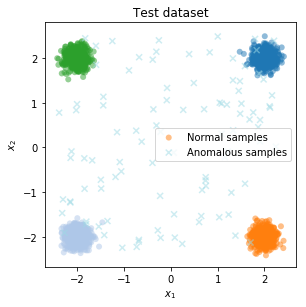

In [17]:
plt.clf()
fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/15.0),
           edgecolor='none', alpha=0.5, label="Normal samples")

ax.scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/15),
       edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')

ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Test dataset")
ax.legend()
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()

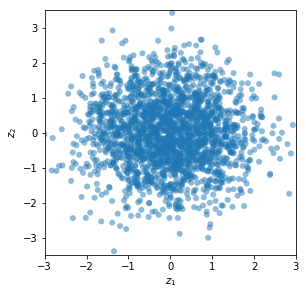

In [18]:
# create Z dataset

datasetZ_test = sample_GMM(X_np_data_test.shape[0], means_z, variances_z, priors_z, sources=('features', ))
save_path = result_dir + 'Z_gmm_data_test.png'
# plot_GMM(dataset, save_path)

Z_np_data_test = datasetZ_test.data['samples']
Z_targets_test = datasetZ_test.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_np_data_test[:, 0], Z_np_data_test[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(save_path, transparent=True, bbox_inches='tight')
plt.show()

In [19]:
### Testing

In [20]:


x = torch.Tensor(X_np_data_test) 
z = torch.Tensor(Z_np_data_test)
"""imz = sess.run(q_z, feed_dict=feed_dict)
rmz = sess.run(rec_z, feed_dict=feed_dict)
imx = sess.run(p_x, feed_dict=feed_dict)
rmx = sess.run(rec_x, feed_dict=feed_dict)"""

imx = (gen(z).detach())
imz = inf(x).detach()
rmz = inf(imx).detach()
rmx = gen(imz).detach()

imz = imz.numpy()
imx = imx.numpy()
rmz = rmz.numpy()
rmx = rmx.numpy()

mahalanobis_dis_z = torch.norm(inf(x), p=2, dim=1)

score_dz = mahalanobis_dis_z

score = score_dz #+ score_dxx
score = np.linalg.norm(imz, ord=2, axis=1, keepdims = False)
print(score)
def zmar(imz):
    return np.linalg.norm(imz, ord=2, axis=1, keepdims=False)



[0.66726387 0.67449105 0.9209634  ... 0.89554876 1.3076015  0.31575522]


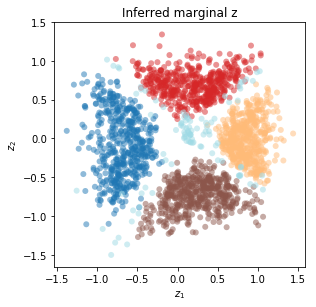

In [21]:


## inferred marginal z
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ll = X_targets_test
ax.scatter(imz[:, 0], imz[:, 1], c=cm.tab20(ll.astype(float)/input_dim/3.0),
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title("Inferred marginal z")
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()



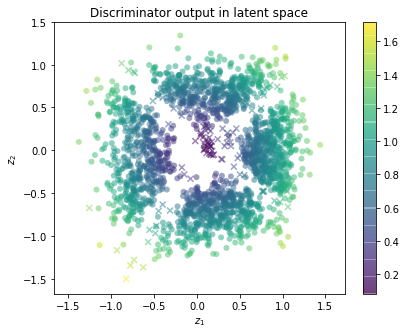

In [23]:


import matplotlib as mpl
## discriminator z choice on latent - v3
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 5))

colors = score#zmar(score)
norm = mpl.colors.Normalize(vmin=min(colors), vmax=max(colors))

im = ax.scatter(imz[idx_inliers, 0], imz[idx_inliers, 1], c=colors[idx_inliers],
        edgecolor='none', alpha=0.5, label="Normal samples", marker='o', norm=norm)

im = ax.scatter(imz[idx_outliers, 0], imz[idx_outliers, 1], c=colors[idx_outliers],
        edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x', norm=norm)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
fig_mz.colorbar(im)
ax.axis('on')
plt.axis('equal')
ax.set_title("Discriminator output in latent space")
plt.savefig(result_dir + 'inferred_{}_mz_disc.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()



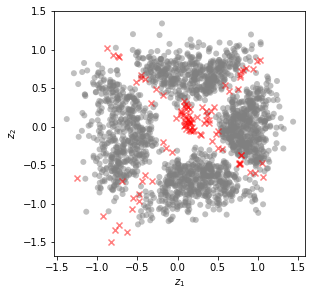

In [24]:
## discriminator z choice on latent - v2
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(imz[idx_inliers][:, 0], imz[idx_inliers][:, 1], c='grey',
        edgecolor='none', alpha=0.5)
ax.scatter(imz[idx_outliers][:, 0], imz[idx_outliers][:, 1], c='r',
        edgecolor='none', alpha=0.5, marker='x')
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

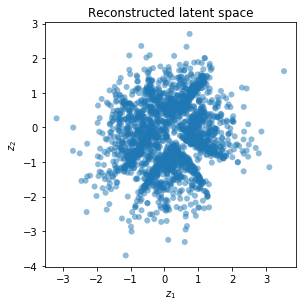

In [25]:


##  reconstructed z
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(rmz[:, 0], rmz[:, 1],
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title('Reconstructed latent space')
plt.savefig(result_dir + 'reconstruct_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()



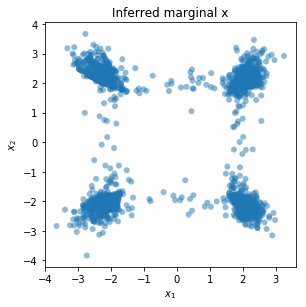

In [26]:
## inferred marginal x
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(imx[:, 0], imx[:, 1],
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Inferred marginal x")
plt.savefig(result_dir + 'inferred_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

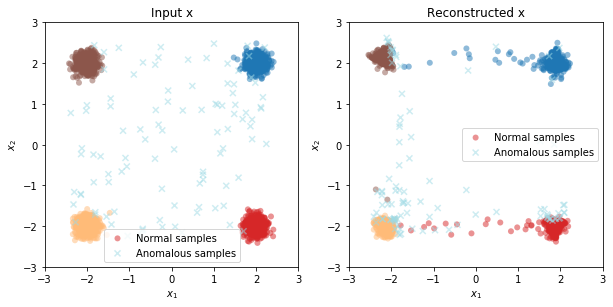

In [27]:
##  reconstructed x
fig_mx, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))
ax[0].scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[0].scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[0].set_xlabel('$x_1$'); ax[0].set_ylabel('$x_2$')
ax[0].axis('on')
ax[0].set_xlim(-3, 3); ax[0].set_ylim(-3, 3)
ax[0].legend()
ax[0].set_title("Input x")

ax[1].scatter(rmx[idx_inliers, 0], rmx[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[1].scatter(rmx[idx_outliers, 0], rmx[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[1].set_xlim(-3, 3); ax[1].set_ylim(-3, 3)
ax[1].set_xlabel('$x_1$'); ax[1].set_ylabel('$x_2$')
ax[1].axis('on')
ax[1].legend()
ax[1].set_title("Reconstructed x")
plt.savefig(result_dir + 'reconstruct_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

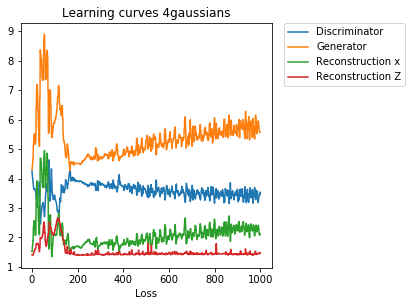

In [28]:

## learning curves
fig_curve, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.plot(FD, label="Discriminator")
ax.plot(np.array(FG)[:,0], label="Generator")
ax.plot(np.array(FG)[:,1], label="Reconstruction x")
ax.plot(np.array(FG)[:,2], label="Reconstruction Z")
plt.xlabel('Iteration')
plt.xlabel('Loss')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('on')
ax.set_title("Learning curves {}".format(DATASET))
plt.savefig(result_dir + 'learning_curves_{}.png'.format(DATASET), bbox_inches='tight')
plt.show()
